## 1. Import Libraries and Setup

In [2]:
# Mount Google Drive (for Colab)
try:
    from google.colab import drive
    drive.mount('/content/drive')

    # Change to the working directory
    import os
    os.chdir('/content/drive/MyDrive/DLA GM5/src')
    print("Google Drive mounted successfully")
    print(f"Working directory: {os.getcwd()}")
except:
    print("Not running on Colab or Drive already mounted")

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Subset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import os
from datetime import datetime

# Import functions from finetune_googlenet.py
from finetune_googlenet import load_pretrained_googlenet, train_epoch, multi_crop_evaluate

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

Not running on Colab or Drive already mounted
Using device: cpu


## 2. Configuration Parameters

In [3]:
# Training configuration
config = {
    'num_classes': 10,              # CIFAR-10 has 10 classes
    'batch_size': 128,              # Batch size for training
    'num_epochs': 20,               # Number of training epochs
    'learning_rate': 0.001,         # Initial learning rate
    'momentum': 0.9,                # SGD momentum
    'weight_decay': 1e-4,           # L2 regularization
    'freeze_backbone': True,       # Whether to freeze backbone layers
    'data_dir': './data',           # Directory to store dataset
    'save_dir': './results',        # Directory to save checkpoints
    'experiment_name': f'finetune_{datetime.now().strftime("%Y%m%d_%H%M%S")}',
    'val_num_crops': 1,             # Number of crops for validation (1, 10, or 144)
                                     # 1=fast single crop, 10=more accurate, 144=very slow but most accurate
}

# Create save directory
save_path = os.path.join(config['save_dir'], config['experiment_name'])
os.makedirs(save_path, exist_ok=True)
print(f"Results will be saved to: {save_path}")

Results will be saved to: ./results/finetune_20251215_232300


## 3. Prepare CIFAR-10 Dataset

In [4]:
# Data augmentation and normalization for training
# Following GoogLeNet paper methodology:
# - Random crops with size distributed evenly between 8% and 100% of image area
# - Aspect ratio constrained to [3/4, 4/3]
# - Photometric distortions (color jittering)
# - Final crop size: 224x224 with zero mean (ImageNet normalization)

train_transform = transforms.Compose([
    transforms.Resize(256),  # First resize to have enough resolution
    # Random resized crop: samples patches between 8% and 100% of area
    # with aspect ratio between 3/4 and 4/3
    transforms.RandomResizedCrop(
        224,
        scale=(0.7,1.0),  # changed to 70% to 100% of image area, 8% being way too low
        ratio=(3./4., 4./3.),   # Aspect ratio range 
        interpolation=transforms.InterpolationMode.BILINEAR
    ),
    # transforms.RandomHorizontalFlip(),
    # Photometric distortions (as mentioned by Andrew Howard)
    transforms.ColorJitter(
        brightness=0.4,
        contrast=0.4,
        saturation=0.4,
        hue=0.1
    ),
    transforms.ToTensor(),
    # Zero mean normalization (ImageNet stats)
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                       std=[0.229, 0.224, 0.225])
])

# Load CIFAR-10 dataset
print("Loading CIFAR-10 dataset...")

# Load full training set with transforms applied
full_train_dataset = datasets.CIFAR10(
    root=config['data_dir'],
    train=True,
    download=True,
    transform=train_transform  # Apply augmentation to training data
)

# Load validation set WITHOUT any transforms (raw data)
# Transforms will be applied later by multi_crop_evaluate
full_train_dataset_val = datasets.CIFAR10(
    root=config['data_dir'],
    train=True,
    download=True,
    transform=None  # NO transforms - keep raw data
)

# Load test set (kept separate for final multi-crop evaluation)
test_dataset_raw = datasets.CIFAR10(
    root=config['data_dir'],
    train=False,
    download=True,
    transform=None  # No transforms - multi_crop_evaluate handles everything
)

# Split training set into train (90%) and validation (10%)

train_size = int(0.9 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size

# Set seed for reproducible split
torch.manual_seed(42)
train_indices, val_indices = random_split(
    range(len(full_train_dataset)),
    [train_size, val_size]
)

# Create train dataset with augmentation and validation dataset without transforms
train_dataset = Subset(full_train_dataset, train_indices.indices)
val_dataset = Subset(full_train_dataset_val, val_indices.indices)

# Create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=config['batch_size'],
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=config['batch_size'],
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

print(f"Training samples: {len(train_dataset)} (90% of original training set)")
print(f"Validation samples: {len(val_dataset)} (10% of original training set)")
print(f"Test samples: {len(test_dataset_raw)} (kept separate for final evaluation)")
print(f"Classes: {full_train_dataset.classes}")

Loading CIFAR-10 dataset...
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Training samples: 45000 (90% of original training set)
Validation samples: 5000 (10% of original training set)
Test samples: 10000 (kept separate for final evaluation)
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


## 4. Load Pretrained GoogLeNet Model

In [5]:
# Load pretrained model

model = load_pretrained_googlenet(
    num_classes=config['num_classes'],
    freeze_backbone=config['freeze_backbone'],
    use_aux_logits=True
)

# Disable auxiliary classifiers for fine-tuning because :
# 1. Auxiliary classifiers have random (untrained) weights for CIFAR-10
# 2. They add noise to the gradient signal
# 3. They slow down training unnecessarily
model.aux_logits = False
model.aux1 = None
model.aux2 = None

model = model.to(device)

# Count trainable parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Frozen parameters: {total_params - trainable_params:,}")

Pretrained weights loaded from ImageNet
Final layer adapted for 10 classes
Freezing backbone layers (only training final classifier)...
Backbone frozen

Total parameters: 5,610,154
Trainable parameters: 10,250
Frozen parameters: 5,599,904


/home/malak/anaconda3/envs/FSDenv250/lib/python3.11/site-packages/torchvision/models/googlenet.py:341: UserWarning: auxiliary heads in the pretrained googlenet model are NOT pretrained, so make sure to train them
  warnings.warn(


## 5. Setup Training Components

In [6]:
# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer (SGD with momentum as in the paper)
optimizer = optim.SGD(
    model.parameters(),
    lr=config['learning_rate'],
    momentum=config['momentum'],
    weight_decay=config['weight_decay']
)

# Learning rate scheduler (step decay)
scheduler = optim.lr_scheduler.StepLR(
    optimizer,
    step_size=5,
    gamma=0.8
)

print("Training components initialized:")
print(f"  Criterion: CrossEntropyLoss")
print(f"  Optimizer: SGD (lr={config['learning_rate']}, momentum={config['momentum']})")

Training components initialized:
  Criterion: CrossEntropyLoss
  Optimizer: SGD (lr=0.001, momentum=0.9)


## 6. Training Loop with Loss Visualization


Starting Training

Epoch [1/20] - Learning Rate: 0.001000
----------------------------------------------------------------------
  Batch [100/352] Loss: 1.8912 Acc: 31.55%
  Batch [200/352] Loss: 1.6316 Acc: 44.08%
  Batch [300/352] Loss: 1.4252 Acc: 50.29%

Evaluating with 1-crop testing...
  Processed 100/5000 images - Top-1: 57.00%, Top-5: 95.00%, Loss: 1.4164
  Processed 200/5000 images - Top-1: 66.00%, Top-5: 95.00%, Loss: 1.3317
  Processed 300/5000 images - Top-1: 67.67%, Top-5: 96.00%, Loss: 1.2983
  Processed 400/5000 images - Top-1: 70.75%, Top-5: 96.75%, Loss: 1.2671
  Processed 500/5000 images - Top-1: 70.60%, Top-5: 96.40%, Loss: 1.2810
  Processed 600/5000 images - Top-1: 70.50%, Top-5: 96.83%, Loss: 1.2787
  Processed 700/5000 images - Top-1: 70.71%, Top-5: 96.71%, Loss: 1.2815
  Processed 800/5000 images - Top-1: 70.88%, Top-5: 96.75%, Loss: 1.2836
  Processed 900/5000 images - Top-1: 71.11%, Top-5: 96.56%, Loss: 1.2775
  Processed 1000/5000 images - Top-1: 71.20%, Top

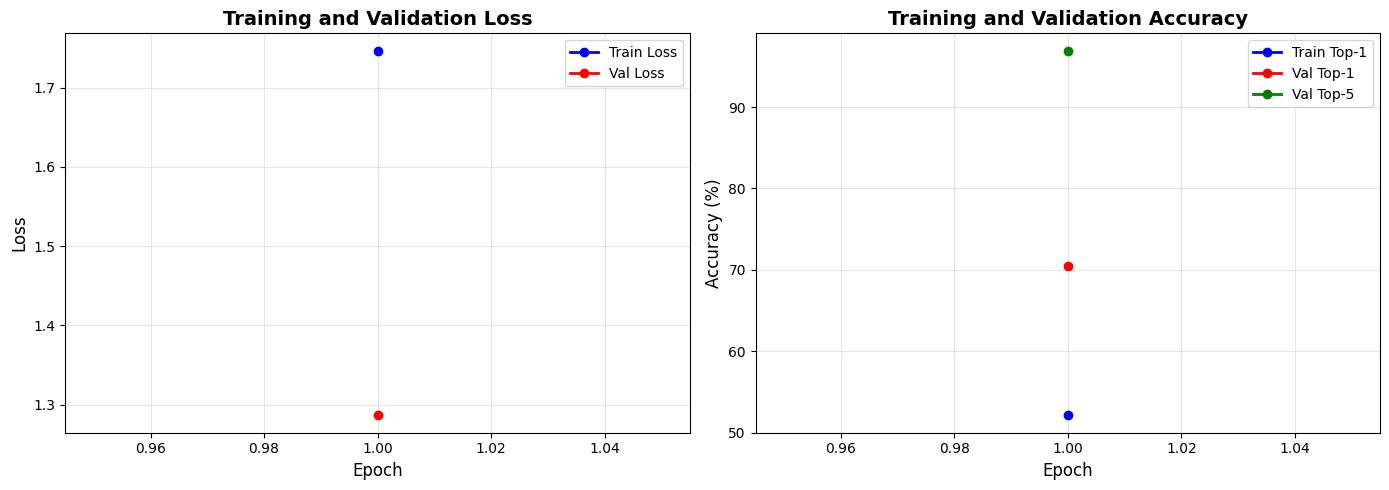


Epoch [2/20] - Learning Rate: 0.001000
----------------------------------------------------------------------
  Batch [100/352] Loss: 1.2588 Acc: 65.76%
  Batch [200/352] Loss: 1.2016 Acc: 66.27%
  Batch [300/352] Loss: 1.2243 Acc: 66.64%

Evaluating with 1-crop testing...
  Processed 100/5000 images - Top-1: 61.00%, Top-5: 96.00%, Loss: 1.2192
  Processed 200/5000 images - Top-1: 69.00%, Top-5: 97.50%, Loss: 1.0956
  Processed 300/5000 images - Top-1: 71.00%, Top-5: 97.67%, Loss: 1.0449
  Processed 400/5000 images - Top-1: 74.25%, Top-5: 98.00%, Loss: 1.0037
  Processed 500/5000 images - Top-1: 73.40%, Top-5: 97.80%, Loss: 1.0238
  Processed 600/5000 images - Top-1: 72.67%, Top-5: 98.17%, Loss: 1.0182
  Processed 700/5000 images - Top-1: 72.57%, Top-5: 98.14%, Loss: 1.0186
  Processed 800/5000 images - Top-1: 72.50%, Top-5: 98.12%, Loss: 1.0221
  Processed 900/5000 images - Top-1: 72.67%, Top-5: 98.11%, Loss: 1.0178
  Processed 1000/5000 images - Top-1: 72.80%, Top-5: 98.00%, Loss: 1

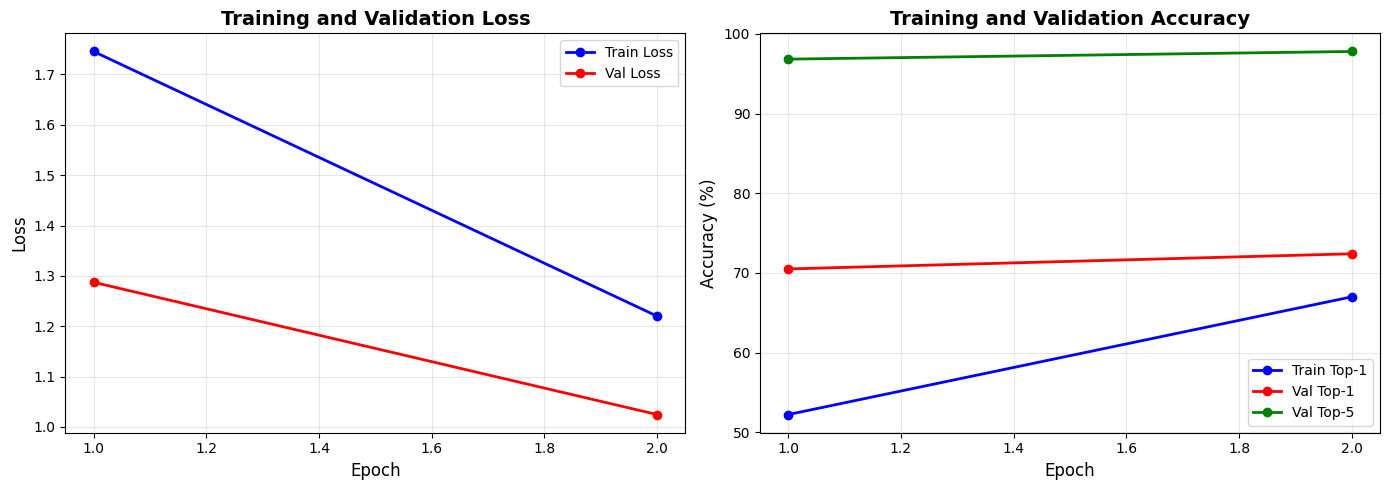


Epoch [3/20] - Learning Rate: 0.001000
----------------------------------------------------------------------
  Batch [100/352] Loss: 1.1107 Acc: 67.39%
  Batch [200/352] Loss: 1.0392 Acc: 67.85%
  Batch [300/352] Loss: 0.9830 Acc: 67.97%

Evaluating with 1-crop testing...
  Processed 100/5000 images - Top-1: 62.00%, Top-5: 96.00%, Loss: 1.1465
  Processed 200/5000 images - Top-1: 70.50%, Top-5: 97.50%, Loss: 0.9954
  Processed 300/5000 images - Top-1: 72.67%, Top-5: 97.67%, Loss: 0.9394
  Processed 400/5000 images - Top-1: 75.00%, Top-5: 98.00%, Loss: 0.8964
  Processed 500/5000 images - Top-1: 74.20%, Top-5: 97.80%, Loss: 0.9109
  Processed 600/5000 images - Top-1: 73.83%, Top-5: 98.17%, Loss: 0.9044
  Processed 700/5000 images - Top-1: 73.43%, Top-5: 98.14%, Loss: 0.9030
  Processed 800/5000 images - Top-1: 73.50%, Top-5: 98.12%, Loss: 0.9090
  Processed 900/5000 images - Top-1: 73.67%, Top-5: 98.00%, Loss: 0.9054
  Processed 1000/5000 images - Top-1: 74.00%, Top-5: 97.90%, Loss: 0

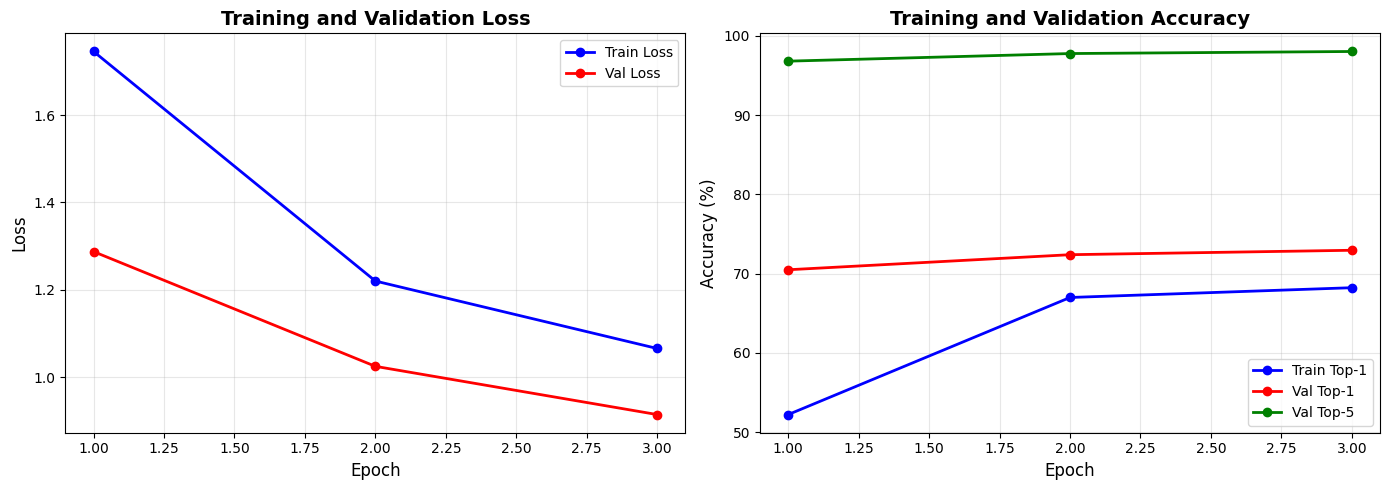


Epoch [4/20] - Learning Rate: 0.001000
----------------------------------------------------------------------
  Batch [100/352] Loss: 1.1831 Acc: 68.64%
  Batch [200/352] Loss: 1.0163 Acc: 69.11%
  Batch [300/352] Loss: 0.9936 Acc: 69.47%

Evaluating with 1-crop testing...
  Processed 100/5000 images - Top-1: 61.00%, Top-5: 95.00%, Loss: 1.1024
  Processed 200/5000 images - Top-1: 71.00%, Top-5: 97.00%, Loss: 0.9366
  Processed 300/5000 images - Top-1: 73.67%, Top-5: 97.33%, Loss: 0.8790
  Processed 400/5000 images - Top-1: 76.25%, Top-5: 97.75%, Loss: 0.8335
  Processed 500/5000 images - Top-1: 75.80%, Top-5: 97.80%, Loss: 0.8462
  Processed 600/5000 images - Top-1: 75.17%, Top-5: 98.17%, Loss: 0.8381
  Processed 700/5000 images - Top-1: 74.71%, Top-5: 98.14%, Loss: 0.8370
  Processed 800/5000 images - Top-1: 74.62%, Top-5: 98.12%, Loss: 0.8452
  Processed 900/5000 images - Top-1: 74.33%, Top-5: 98.00%, Loss: 0.8449
  Processed 1000/5000 images - Top-1: 74.60%, Top-5: 98.00%, Loss: 0

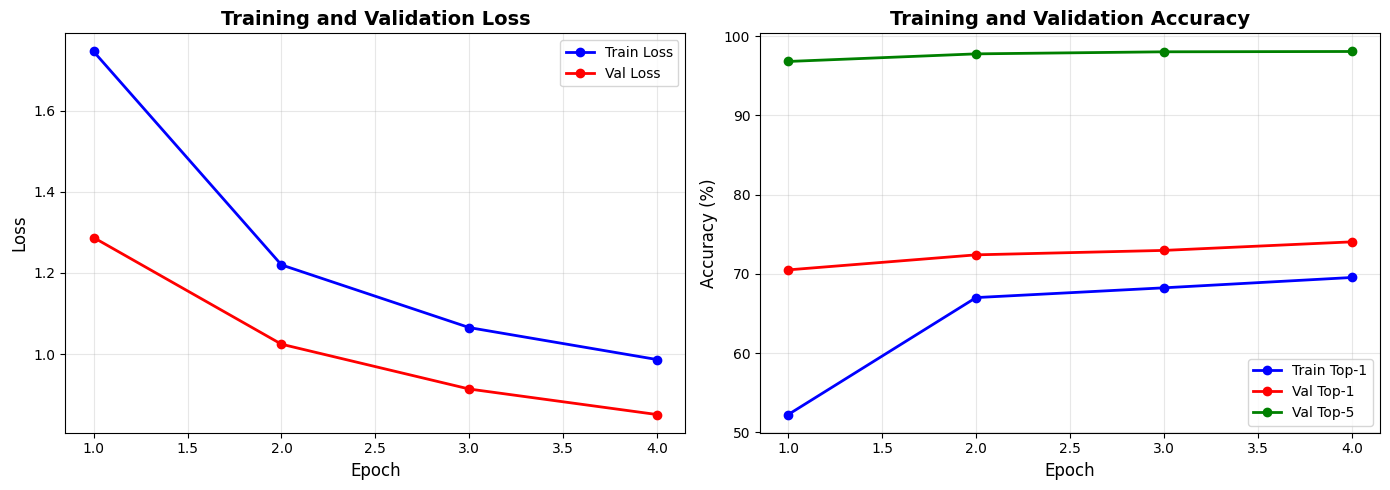


Epoch [5/20] - Learning Rate: 0.001000
----------------------------------------------------------------------
  Batch [100/352] Loss: 0.9322 Acc: 70.73%
  Batch [200/352] Loss: 1.0078 Acc: 70.31%
  Batch [300/352] Loss: 0.8691 Acc: 70.20%

Evaluating with 1-crop testing...
  Processed 100/5000 images - Top-1: 61.00%, Top-5: 95.00%, Loss: 1.0856
  Processed 200/5000 images - Top-1: 71.50%, Top-5: 97.00%, Loss: 0.9053
  Processed 300/5000 images - Top-1: 74.00%, Top-5: 97.33%, Loss: 0.8464
  Processed 400/5000 images - Top-1: 76.25%, Top-5: 97.75%, Loss: 0.7988
  Processed 500/5000 images - Top-1: 75.80%, Top-5: 97.80%, Loss: 0.8104
  Processed 600/5000 images - Top-1: 75.50%, Top-5: 98.17%, Loss: 0.8013
  Processed 700/5000 images - Top-1: 75.14%, Top-5: 98.14%, Loss: 0.8001
  Processed 800/5000 images - Top-1: 74.62%, Top-5: 98.12%, Loss: 0.8091
  Processed 900/5000 images - Top-1: 74.56%, Top-5: 98.11%, Loss: 0.8085
  Processed 1000/5000 images - Top-1: 74.70%, Top-5: 98.10%, Loss: 0


Epoch [6/20] - Learning Rate: 0.000800
----------------------------------------------------------------------
  Batch [100/352] Loss: 0.9037 Acc: 70.71%
  Batch [200/352] Loss: 0.8840 Acc: 70.42%
  Batch [300/352] Loss: 1.0490 Acc: 70.50%

Evaluating with 1-crop testing...
  Processed 100/5000 images - Top-1: 63.00%, Top-5: 96.00%, Loss: 1.0728
  Processed 200/5000 images - Top-1: 72.00%, Top-5: 98.00%, Loss: 0.8871
  Processed 300/5000 images - Top-1: 73.33%, Top-5: 98.00%, Loss: 0.8262
  Processed 400/5000 images - Top-1: 75.75%, Top-5: 98.25%, Loss: 0.7804
  Processed 500/5000 images - Top-1: 75.20%, Top-5: 98.40%, Loss: 0.7922
  Processed 600/5000 images - Top-1: 75.33%, Top-5: 98.67%, Loss: 0.7811
  Processed 700/5000 images - Top-1: 75.29%, Top-5: 98.57%, Loss: 0.7798
  Processed 800/5000 images - Top-1: 75.00%, Top-5: 98.50%, Loss: 0.7875
  Processed 900/5000 images - Top-1: 75.22%, Top-5: 98.33%, Loss: 0.7867
  Processed 1000/5000 images - Top-1: 75.30%, Top-5: 98.40%, Loss: 0


Epoch [7/20] - Learning Rate: 0.000800
----------------------------------------------------------------------
  Batch [100/352] Loss: 0.8804 Acc: 70.98%
  Batch [200/352] Loss: 0.8324 Acc: 70.87%
  Batch [300/352] Loss: 0.9344 Acc: 70.93%

Evaluating with 1-crop testing...
  Processed 100/5000 images - Top-1: 60.00%, Top-5: 96.00%, Loss: 1.0688
  Processed 200/5000 images - Top-1: 70.00%, Top-5: 98.00%, Loss: 0.8712
  Processed 300/5000 images - Top-1: 72.00%, Top-5: 98.00%, Loss: 0.8100
  Processed 400/5000 images - Top-1: 74.50%, Top-5: 98.25%, Loss: 0.7657
  Processed 500/5000 images - Top-1: 74.00%, Top-5: 98.20%, Loss: 0.7754
  Processed 600/5000 images - Top-1: 74.00%, Top-5: 98.50%, Loss: 0.7649
  Processed 700/5000 images - Top-1: 74.29%, Top-5: 98.43%, Loss: 0.7612
  Processed 800/5000 images - Top-1: 74.12%, Top-5: 98.38%, Loss: 0.7713
  Processed 900/5000 images - Top-1: 74.00%, Top-5: 98.22%, Loss: 0.7718
  Processed 1000/5000 images - Top-1: 74.30%, Top-5: 98.30%, Loss: 0


Epoch [8/20] - Learning Rate: 0.000800
----------------------------------------------------------------------
  Batch [100/352] Loss: 0.8345 Acc: 71.30%
  Batch [200/352] Loss: 0.9039 Acc: 71.29%
  Batch [300/352] Loss: 1.0554 Acc: 71.27%

Evaluating with 1-crop testing...
  Processed 100/5000 images - Top-1: 60.00%, Top-5: 95.00%, Loss: 1.0634
  Processed 200/5000 images - Top-1: 70.50%, Top-5: 97.50%, Loss: 0.8635
  Processed 300/5000 images - Top-1: 72.67%, Top-5: 97.67%, Loss: 0.8018
  Processed 400/5000 images - Top-1: 75.00%, Top-5: 98.00%, Loss: 0.7568
  Processed 500/5000 images - Top-1: 74.80%, Top-5: 98.20%, Loss: 0.7631
  Processed 600/5000 images - Top-1: 75.00%, Top-5: 98.50%, Loss: 0.7518
  Processed 700/5000 images - Top-1: 75.14%, Top-5: 98.43%, Loss: 0.7486
  Processed 800/5000 images - Top-1: 74.75%, Top-5: 98.38%, Loss: 0.7599
  Processed 900/5000 images - Top-1: 74.78%, Top-5: 98.33%, Loss: 0.7614
  Processed 1000/5000 images - Top-1: 75.00%, Top-5: 98.40%, Loss: 0


Epoch [9/20] - Learning Rate: 0.000800
----------------------------------------------------------------------
  Batch [100/352] Loss: 0.9079 Acc: 71.73%
  Batch [200/352] Loss: 0.8222 Acc: 71.70%
  Batch [300/352] Loss: 0.8719 Acc: 71.54%

Evaluating with 1-crop testing...
  Processed 100/5000 images - Top-1: 62.00%, Top-5: 96.00%, Loss: 1.0505
  Processed 200/5000 images - Top-1: 71.00%, Top-5: 98.00%, Loss: 0.8484
  Processed 300/5000 images - Top-1: 73.67%, Top-5: 98.33%, Loss: 0.7813
  Processed 400/5000 images - Top-1: 76.50%, Top-5: 98.50%, Loss: 0.7359
  Processed 500/5000 images - Top-1: 76.00%, Top-5: 98.20%, Loss: 0.7463
  Processed 600/5000 images - Top-1: 76.17%, Top-5: 98.50%, Loss: 0.7341
  Processed 700/5000 images - Top-1: 76.00%, Top-5: 98.43%, Loss: 0.7326
  Processed 800/5000 images - Top-1: 76.00%, Top-5: 98.38%, Loss: 0.7400
  Processed 900/5000 images - Top-1: 76.00%, Top-5: 98.22%, Loss: 0.7413
  Processed 1000/5000 images - Top-1: 76.00%, Top-5: 98.30%, Loss: 0


Epoch [10/20] - Learning Rate: 0.000800
----------------------------------------------------------------------
  Batch [100/352] Loss: 0.7825 Acc: 71.74%
  Batch [200/352] Loss: 0.9144 Acc: 71.63%
  Batch [300/352] Loss: 0.7883 Acc: 71.76%

Evaluating with 1-crop testing...
  Processed 100/5000 images - Top-1: 60.00%, Top-5: 96.00%, Loss: 1.0466
  Processed 200/5000 images - Top-1: 70.50%, Top-5: 98.00%, Loss: 0.8353
  Processed 300/5000 images - Top-1: 72.33%, Top-5: 98.00%, Loss: 0.7736
  Processed 400/5000 images - Top-1: 75.00%, Top-5: 98.25%, Loss: 0.7289
  Processed 500/5000 images - Top-1: 74.80%, Top-5: 98.40%, Loss: 0.7377
  Processed 600/5000 images - Top-1: 75.17%, Top-5: 98.67%, Loss: 0.7256
  Processed 700/5000 images - Top-1: 75.57%, Top-5: 98.57%, Loss: 0.7222
  Processed 800/5000 images - Top-1: 75.12%, Top-5: 98.62%, Loss: 0.7325
  Processed 900/5000 images - Top-1: 75.00%, Top-5: 98.56%, Loss: 0.7341
  Processed 1000/5000 images - Top-1: 75.30%, Top-5: 98.60%, Loss: 

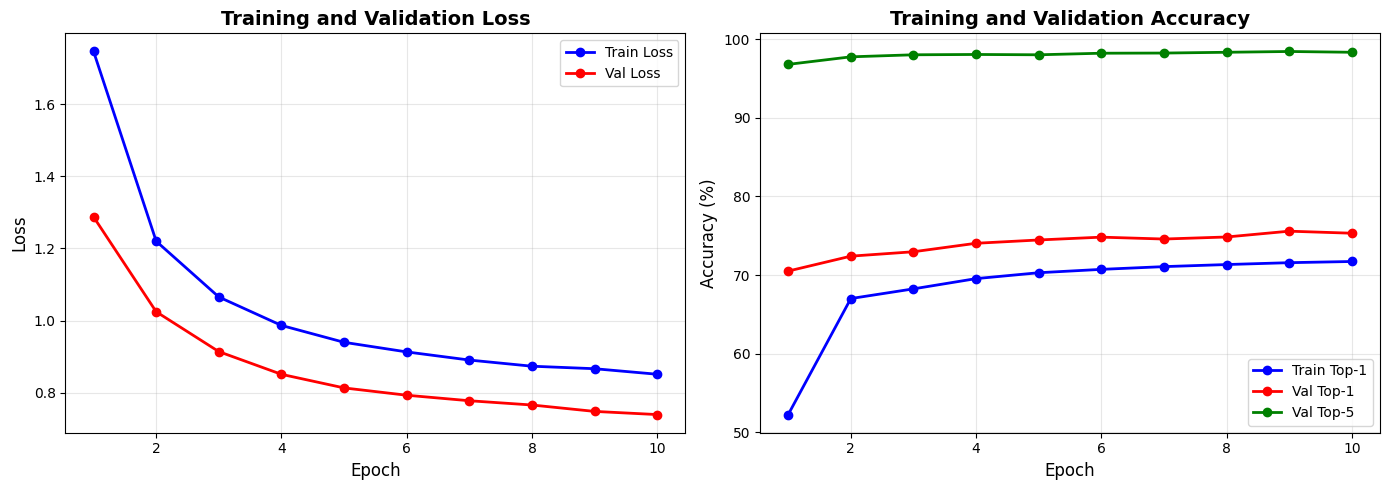


Epoch [11/20] - Learning Rate: 0.000640
----------------------------------------------------------------------
  Batch [100/352] Loss: 0.9272 Acc: 71.48%
  Batch [200/352] Loss: 0.8947 Acc: 71.90%
  Batch [300/352] Loss: 0.8003 Acc: 72.00%

Evaluating with 1-crop testing...
  Processed 100/5000 images - Top-1: 63.00%, Top-5: 96.00%, Loss: 1.0324
  Processed 200/5000 images - Top-1: 72.50%, Top-5: 98.00%, Loss: 0.8232
  Processed 300/5000 images - Top-1: 74.00%, Top-5: 98.33%, Loss: 0.7617
  Processed 400/5000 images - Top-1: 76.50%, Top-5: 98.50%, Loss: 0.7179
  Processed 500/5000 images - Top-1: 76.20%, Top-5: 98.60%, Loss: 0.7279
  Processed 600/5000 images - Top-1: 76.67%, Top-5: 98.83%, Loss: 0.7148
  Processed 700/5000 images - Top-1: 76.86%, Top-5: 98.71%, Loss: 0.7120
  Processed 800/5000 images - Top-1: 76.50%, Top-5: 98.75%, Loss: 0.7226
  Processed 900/5000 images - Top-1: 76.22%, Top-5: 98.67%, Loss: 0.7243
  Processed 1000/5000 images - Top-1: 76.50%, Top-5: 98.70%, Loss: 


Epoch [12/20] - Learning Rate: 0.000640
----------------------------------------------------------------------
  Batch [100/352] Loss: 0.8800 Acc: 72.21%
  Batch [200/352] Loss: 0.7406 Acc: 72.12%
  Batch [300/352] Loss: 0.8984 Acc: 72.02%

Evaluating with 1-crop testing...
  Processed 100/5000 images - Top-1: 60.00%, Top-5: 96.00%, Loss: 1.0463
  Processed 200/5000 images - Top-1: 70.50%, Top-5: 98.00%, Loss: 0.8342
  Processed 300/5000 images - Top-1: 72.67%, Top-5: 98.67%, Loss: 0.7664
  Processed 400/5000 images - Top-1: 74.75%, Top-5: 98.75%, Loss: 0.7221
  Processed 500/5000 images - Top-1: 74.60%, Top-5: 98.80%, Loss: 0.7295
  Processed 600/5000 images - Top-1: 75.17%, Top-5: 99.00%, Loss: 0.7163
  Processed 700/5000 images - Top-1: 75.57%, Top-5: 98.86%, Loss: 0.7128
  Processed 800/5000 images - Top-1: 75.25%, Top-5: 98.88%, Loss: 0.7235
  Processed 900/5000 images - Top-1: 75.22%, Top-5: 98.78%, Loss: 0.7257
  Processed 1000/5000 images - Top-1: 75.50%, Top-5: 98.80%, Loss: 

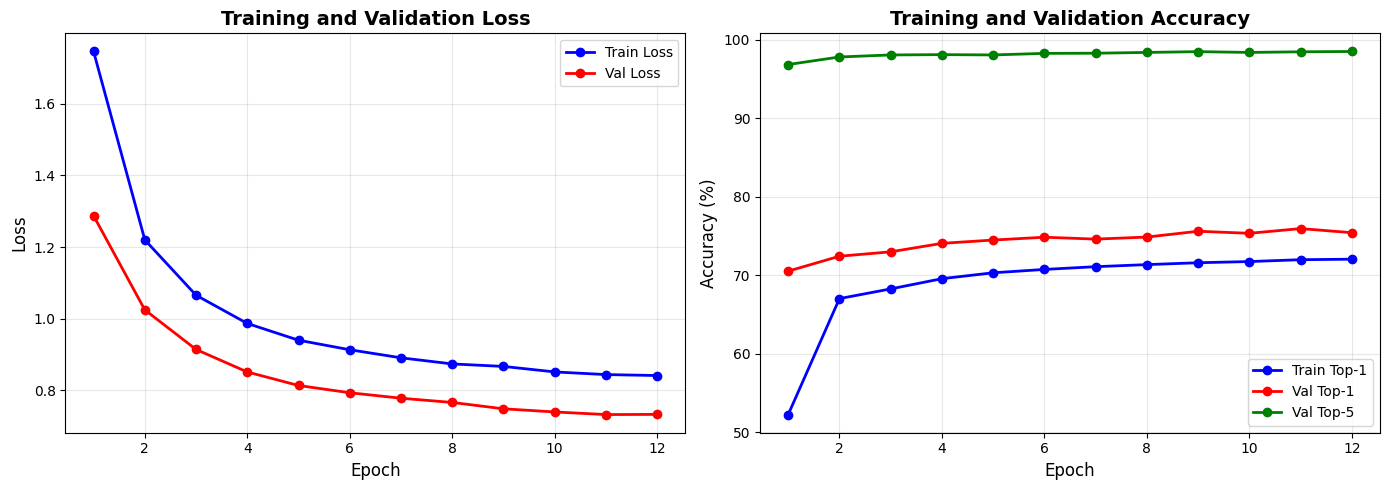


Epoch [13/20] - Learning Rate: 0.000640
----------------------------------------------------------------------
  Batch [100/352] Loss: 0.7702 Acc: 72.45%
  Batch [200/352] Loss: 0.8554 Acc: 72.35%
  Batch [300/352] Loss: 0.9308 Acc: 72.47%

Evaluating with 1-crop testing...
  Processed 100/5000 images - Top-1: 62.00%, Top-5: 96.00%, Loss: 1.0413
  Processed 200/5000 images - Top-1: 72.00%, Top-5: 98.00%, Loss: 0.8182
  Processed 300/5000 images - Top-1: 74.00%, Top-5: 98.67%, Loss: 0.7537
  Processed 400/5000 images - Top-1: 76.50%, Top-5: 98.75%, Loss: 0.7097
  Processed 500/5000 images - Top-1: 76.20%, Top-5: 98.80%, Loss: 0.7177
  Processed 600/5000 images - Top-1: 76.83%, Top-5: 99.00%, Loss: 0.7048
  Processed 700/5000 images - Top-1: 77.00%, Top-5: 98.86%, Loss: 0.7012
  Processed 800/5000 images - Top-1: 76.62%, Top-5: 98.88%, Loss: 0.7120
  Processed 900/5000 images - Top-1: 76.22%, Top-5: 98.78%, Loss: 0.7140
  Processed 1000/5000 images - Top-1: 76.30%, Top-5: 98.80%, Loss: 


Epoch [14/20] - Learning Rate: 0.000640
----------------------------------------------------------------------
  Batch [100/352] Loss: 0.7392 Acc: 72.30%
  Batch [200/352] Loss: 0.8516 Acc: 72.41%
  Batch [300/352] Loss: 0.8720 Acc: 72.43%

Evaluating with 1-crop testing...
  Processed 100/5000 images - Top-1: 60.00%, Top-5: 96.00%, Loss: 1.0519
  Processed 200/5000 images - Top-1: 70.50%, Top-5: 98.00%, Loss: 0.8307
  Processed 300/5000 images - Top-1: 72.67%, Top-5: 98.67%, Loss: 0.7629
  Processed 400/5000 images - Top-1: 75.25%, Top-5: 98.75%, Loss: 0.7179
  Processed 500/5000 images - Top-1: 75.40%, Top-5: 98.80%, Loss: 0.7262
  Processed 600/5000 images - Top-1: 75.83%, Top-5: 99.00%, Loss: 0.7130
  Processed 700/5000 images - Top-1: 76.00%, Top-5: 98.86%, Loss: 0.7076
  Processed 800/5000 images - Top-1: 75.62%, Top-5: 98.88%, Loss: 0.7193
  Processed 900/5000 images - Top-1: 75.33%, Top-5: 98.78%, Loss: 0.7226
  Processed 1000/5000 images - Top-1: 75.50%, Top-5: 98.80%, Loss: 

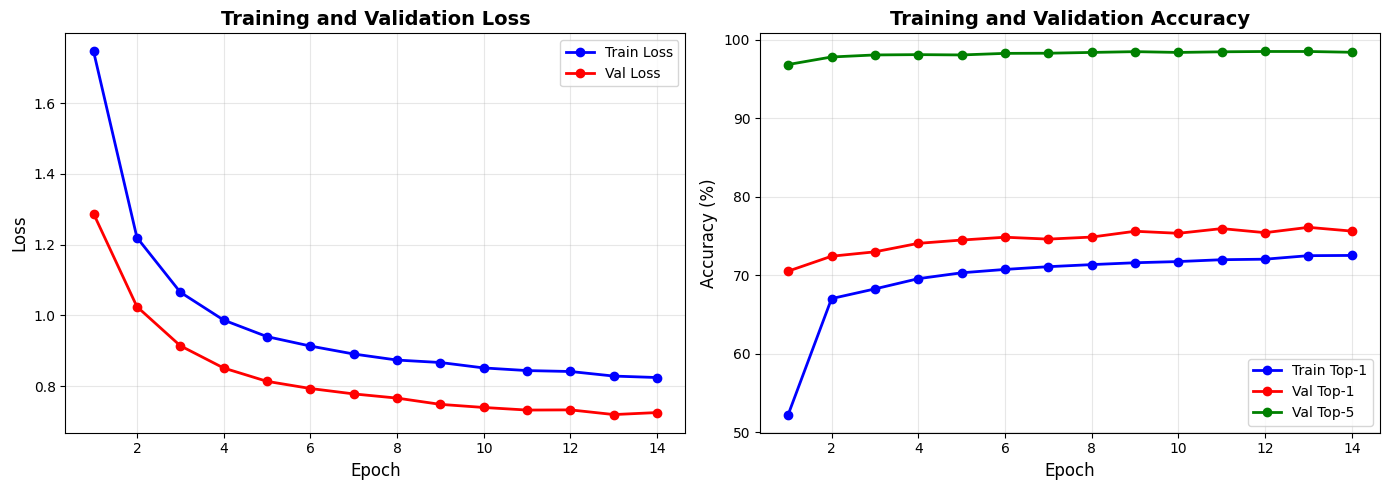


Epoch [15/20] - Learning Rate: 0.000640
----------------------------------------------------------------------
  Batch [100/352] Loss: 0.8889 Acc: 72.88%
  Batch [200/352] Loss: 0.7078 Acc: 72.69%
  Batch [300/352] Loss: 0.8083 Acc: 72.43%

Evaluating with 1-crop testing...
  Processed 100/5000 images - Top-1: 61.00%, Top-5: 96.00%, Loss: 1.0449
  Processed 200/5000 images - Top-1: 72.00%, Top-5: 98.00%, Loss: 0.8201
  Processed 300/5000 images - Top-1: 73.00%, Top-5: 98.67%, Loss: 0.7535
  Processed 400/5000 images - Top-1: 75.75%, Top-5: 98.75%, Loss: 0.7080
  Processed 500/5000 images - Top-1: 75.60%, Top-5: 98.80%, Loss: 0.7147
  Processed 600/5000 images - Top-1: 75.83%, Top-5: 99.00%, Loss: 0.7012
  Processed 700/5000 images - Top-1: 76.00%, Top-5: 98.86%, Loss: 0.6962
  Processed 800/5000 images - Top-1: 75.62%, Top-5: 98.88%, Loss: 0.7074
  Processed 900/5000 images - Top-1: 75.44%, Top-5: 98.78%, Loss: 0.7099
  Processed 1000/5000 images - Top-1: 75.60%, Top-5: 98.80%, Loss: 

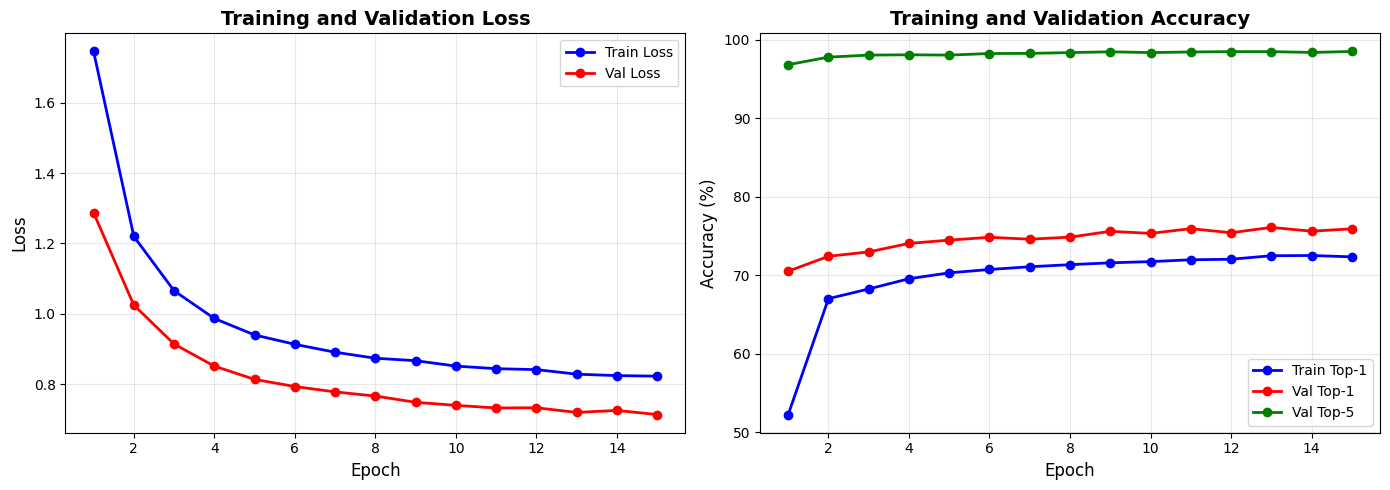


Epoch [16/20] - Learning Rate: 0.000512
----------------------------------------------------------------------
  Batch [100/352] Loss: 0.8666 Acc: 72.48%
  Batch [200/352] Loss: 0.8127 Acc: 72.59%
  Batch [300/352] Loss: 0.8625 Acc: 72.43%

Evaluating with 1-crop testing...
  Processed 100/5000 images - Top-1: 62.00%, Top-5: 96.00%, Loss: 1.0333
  Processed 200/5000 images - Top-1: 71.50%, Top-5: 98.00%, Loss: 0.8144
  Processed 300/5000 images - Top-1: 73.67%, Top-5: 98.67%, Loss: 0.7474
  Processed 400/5000 images - Top-1: 76.25%, Top-5: 98.75%, Loss: 0.7041
  Processed 500/5000 images - Top-1: 76.00%, Top-5: 98.80%, Loss: 0.7101
  Processed 600/5000 images - Top-1: 76.83%, Top-5: 99.00%, Loss: 0.6969
  Processed 700/5000 images - Top-1: 77.00%, Top-5: 98.86%, Loss: 0.6942
  Processed 800/5000 images - Top-1: 76.75%, Top-5: 98.88%, Loss: 0.7051
  Processed 900/5000 images - Top-1: 76.56%, Top-5: 98.78%, Loss: 0.7072
  Processed 1000/5000 images - Top-1: 76.70%, Top-5: 98.80%, Loss: 

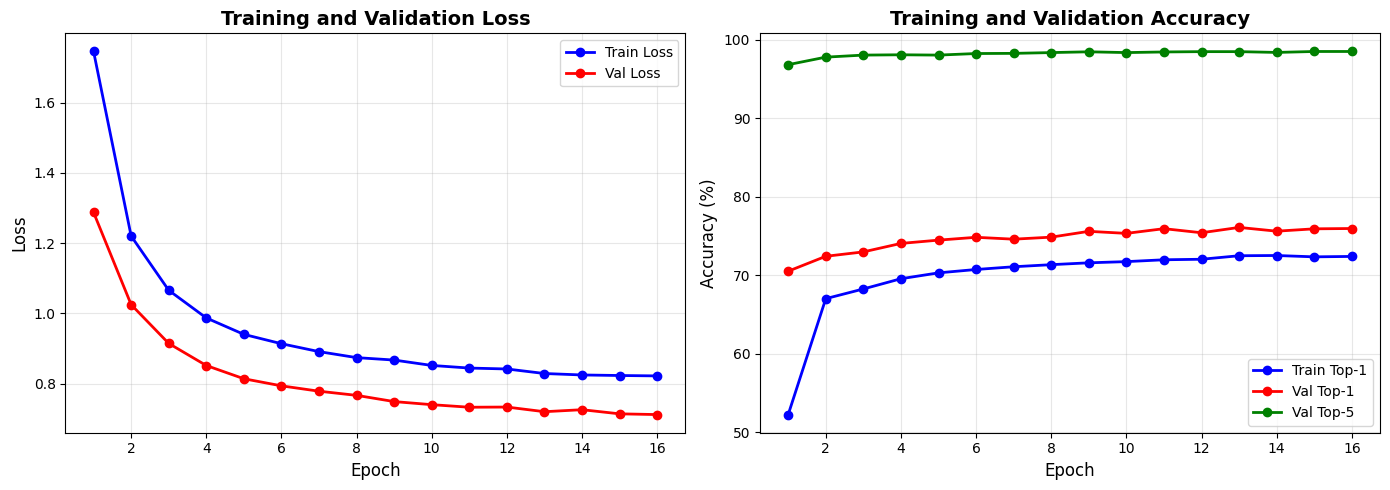


Epoch [17/20] - Learning Rate: 0.000512
----------------------------------------------------------------------
  Batch [100/352] Loss: 0.8432 Acc: 72.62%
  Batch [200/352] Loss: 0.9972 Acc: 72.88%
  Batch [300/352] Loss: 0.9922 Acc: 72.81%

Evaluating with 1-crop testing...
  Processed 100/5000 images - Top-1: 63.00%, Top-5: 96.00%, Loss: 1.0356
  Processed 200/5000 images - Top-1: 72.50%, Top-5: 98.00%, Loss: 0.8146
  Processed 300/5000 images - Top-1: 74.00%, Top-5: 98.67%, Loss: 0.7470
  Processed 400/5000 images - Top-1: 76.25%, Top-5: 98.75%, Loss: 0.7041
  Processed 500/5000 images - Top-1: 76.00%, Top-5: 98.80%, Loss: 0.7092
  Processed 600/5000 images - Top-1: 76.50%, Top-5: 99.00%, Loss: 0.6947
  Processed 700/5000 images - Top-1: 76.57%, Top-5: 98.86%, Loss: 0.6910
  Processed 800/5000 images - Top-1: 76.12%, Top-5: 98.88%, Loss: 0.7033
  Processed 900/5000 images - Top-1: 75.89%, Top-5: 98.78%, Loss: 0.7065
  Processed 1000/5000 images - Top-1: 76.20%, Top-5: 98.80%, Loss: 


Epoch [18/20] - Learning Rate: 0.000512
----------------------------------------------------------------------
  Batch [100/352] Loss: 0.7969 Acc: 72.46%
  Batch [200/352] Loss: 0.7904 Acc: 72.84%
  Batch [300/352] Loss: 0.7763 Acc: 72.78%

Evaluating with 1-crop testing...
  Processed 100/5000 images - Top-1: 65.00%, Top-5: 96.00%, Loss: 1.0324
  Processed 200/5000 images - Top-1: 74.00%, Top-5: 98.00%, Loss: 0.8071
  Processed 300/5000 images - Top-1: 75.33%, Top-5: 98.67%, Loss: 0.7391
  Processed 400/5000 images - Top-1: 77.50%, Top-5: 98.75%, Loss: 0.6960
  Processed 500/5000 images - Top-1: 77.00%, Top-5: 98.80%, Loss: 0.7035
  Processed 600/5000 images - Top-1: 77.50%, Top-5: 99.00%, Loss: 0.6886
  Processed 700/5000 images - Top-1: 77.57%, Top-5: 98.86%, Loss: 0.6863
  Processed 800/5000 images - Top-1: 77.25%, Top-5: 98.88%, Loss: 0.6978
  Processed 900/5000 images - Top-1: 77.00%, Top-5: 98.78%, Loss: 0.7002
  Processed 1000/5000 images - Top-1: 77.10%, Top-5: 98.80%, Loss: 


Epoch [19/20] - Learning Rate: 0.000512
----------------------------------------------------------------------
  Batch [100/352] Loss: 0.6941 Acc: 72.88%
  Batch [200/352] Loss: 0.7737 Acc: 72.52%
  Batch [300/352] Loss: 0.8090 Acc: 72.51%

Evaluating with 1-crop testing...
  Processed 100/5000 images - Top-1: 60.00%, Top-5: 96.00%, Loss: 1.0336
  Processed 200/5000 images - Top-1: 71.00%, Top-5: 98.00%, Loss: 0.8042
  Processed 300/5000 images - Top-1: 72.33%, Top-5: 98.67%, Loss: 0.7383
  Processed 400/5000 images - Top-1: 75.75%, Top-5: 99.00%, Loss: 0.6901
  Processed 500/5000 images - Top-1: 75.40%, Top-5: 99.00%, Loss: 0.6982
  Processed 600/5000 images - Top-1: 76.33%, Top-5: 99.17%, Loss: 0.6832
  Processed 700/5000 images - Top-1: 76.57%, Top-5: 99.00%, Loss: 0.6777
  Processed 800/5000 images - Top-1: 76.38%, Top-5: 99.00%, Loss: 0.6888
  Processed 900/5000 images - Top-1: 76.11%, Top-5: 98.89%, Loss: 0.6928
  Processed 1000/5000 images - Top-1: 76.30%, Top-5: 98.90%, Loss: 

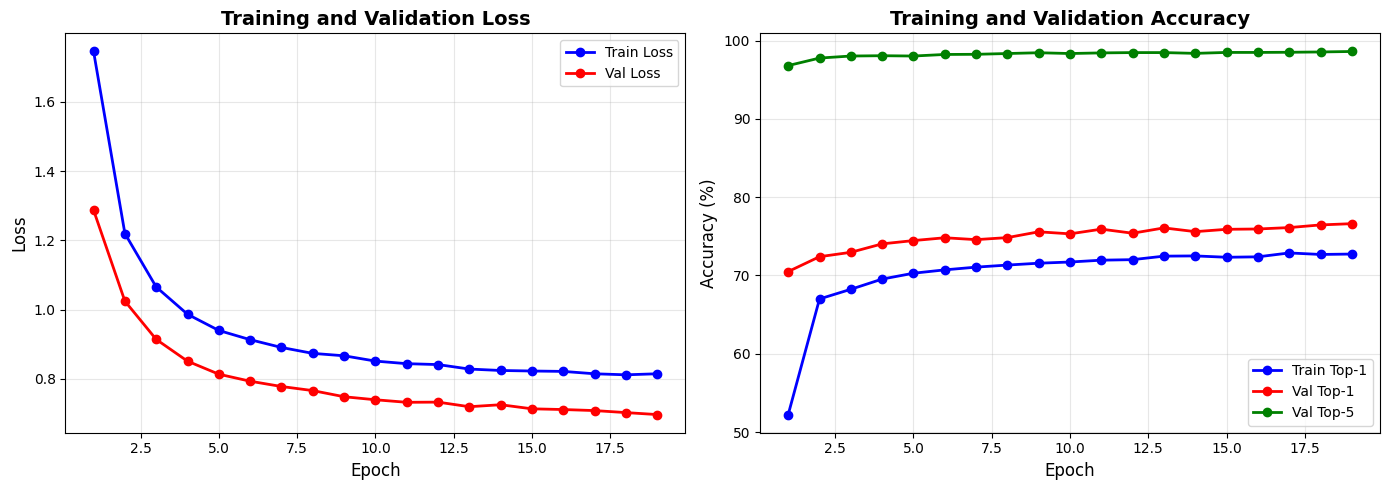


Epoch [20/20] - Learning Rate: 0.000512
----------------------------------------------------------------------
  Batch [100/352] Loss: 0.7426 Acc: 72.48%
  Batch [200/352] Loss: 0.8913 Acc: 72.43%
  Batch [300/352] Loss: 0.7519 Acc: 72.58%

Evaluating with 1-crop testing...
  Processed 100/5000 images - Top-1: 60.00%, Top-5: 96.00%, Loss: 1.0296
  Processed 200/5000 images - Top-1: 70.50%, Top-5: 98.00%, Loss: 0.7978
  Processed 300/5000 images - Top-1: 72.33%, Top-5: 98.67%, Loss: 0.7324
  Processed 400/5000 images - Top-1: 75.25%, Top-5: 99.00%, Loss: 0.6882
  Processed 500/5000 images - Top-1: 75.20%, Top-5: 99.00%, Loss: 0.6955
  Processed 600/5000 images - Top-1: 76.17%, Top-5: 99.17%, Loss: 0.6817
  Processed 700/5000 images - Top-1: 76.43%, Top-5: 99.00%, Loss: 0.6767
  Processed 800/5000 images - Top-1: 76.25%, Top-5: 99.00%, Loss: 0.6894
  Processed 900/5000 images - Top-1: 76.00%, Top-5: 98.89%, Loss: 0.6930
  Processed 1000/5000 images - Top-1: 76.20%, Top-5: 98.90%, Loss: 

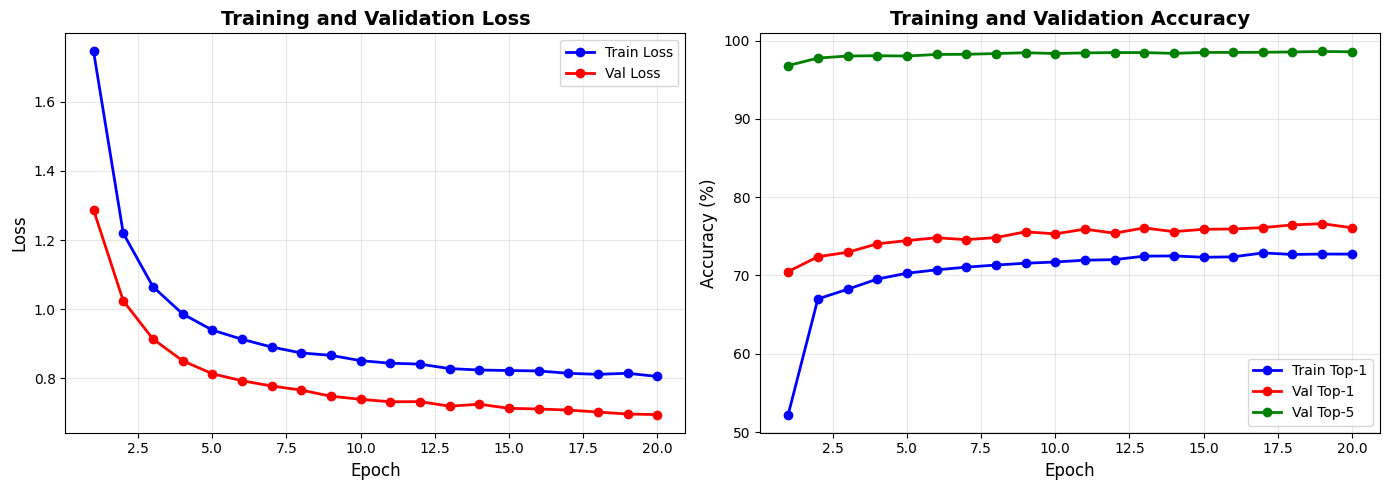


Training Complete!
Best validation top-1 accuracy: 76.62% (Epoch 19)
Best validation top-1 error: 23.38%
Model saved to: ./results/finetune_20251213_224800/best_model.pth


In [ ]:
# BEST MODEL , LESS AGGRESSIVE AUGMENTATION
# Initialize tracking lists
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'val_top5_acc': [],  # Track top-5 accuracy during validation
    'val_top1_err': [],  # Track top-1 error rate
    'val_top5_err': [],  # Track top-5 error rate
    'learning_rates': []
}

best_val_acc = 0.0
best_epoch = 0

print("\n" + "="*70)
print("Starting Training")
print("="*70)

for epoch in range(config['num_epochs']):
    current_lr = optimizer.param_groups[0]['lr']
    print(f"\nEpoch [{epoch+1}/{config['num_epochs']}] - Learning Rate: {current_lr:.6f}")
    print("-" * 70)

    # Train for one epoch
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)

    # Validate using multi-crop evaluation (returns dictionary now)
    val_results = multi_crop_evaluate(
        model, val_dataset, criterion, device,
        num_crops=config['val_num_crops'],
        batch_size=config['batch_size']
    )

    # Extract values from results dictionary
    val_top1 = val_results['top1_acc']
    val_top5 = val_results['top5_acc']
    val_top1_err = val_results['top1_err']
    val_top5_err = val_results['top5_err']
    val_loss = val_results['loss']

    # Update learning rate
    scheduler.step()

    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_top1)
    history['val_top5_acc'].append(val_top5)
    history['val_top1_err'].append(val_top1_err)
    history['val_top5_err'].append(val_top5_err)
    history['learning_rates'].append(current_lr)

    # Print epoch summary
    print(f"\nEpoch {epoch+1} Summary:")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"  Val Loss:   {val_loss:.4f} | Val Top-1: {val_top1:.2f}% | Val Top-5: {val_top5:.2f}%")
    print(f"  Val Error:  Top-1 Err: {val_top1_err:.2f}% | Top-5 Err: {val_top5_err:.2f}%")

    # Save best model based on validation top-1 accuracy
    if val_top1 > best_val_acc:
        best_val_acc = val_top1
        best_epoch = epoch + 1
        checkpoint_path = os.path.join(save_path, 'best_model.pth')
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_top1,
            'val_top5_acc': val_top5,
            'val_top1_err': val_top1_err,
            'val_top5_err': val_top5_err,
            'config': config
        }, checkpoint_path)
        print(f"New best model saved! (Val Top-1: {val_top1:.2f}% / Error: {val_top1_err:.2f}%)")

    # Plot loss curves after each epoch
    plt.figure(figsize=(14, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epoch+2), history['train_loss'], 'b-o', label='Train Loss', linewidth=2)
    plt.plot(range(1, epoch+2), history['val_loss'], 'r-o', label='Val Loss', linewidth=2)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.title('Training and Validation Loss', fontsize=14, fontweight='bold')
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)

    # Plot accuracy (including top-5)
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epoch+2), history['train_acc'], 'b-o', label='Train Top-1', linewidth=2)
    plt.plot(range(1, epoch+2), history['val_acc'], 'r-o', label='Val Top-1', linewidth=2)
    plt.plot(range(1, epoch+2), history['val_top5_acc'], 'g-o', label='Val Top-5', linewidth=2)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Accuracy (%)', fontsize=12)
    plt.title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(os.path.join(save_path, 'training_curves.png'), dpi=150, bbox_inches='tight')
    plt.show()

print("\n" + "="*70)
print("Training Complete!")
print("="*70)
print(f"Best validation top-1 accuracy: {best_val_acc:.2f}% (Epoch {best_epoch})")
print(f"Best validation top-1 error: {100.0 - best_val_acc:.2f}%")
print(f"Model saved to: {checkpoint_path}")

## 7. Final Training Summary

In [ ]:
# BEST MODEL 
# Print final training summary
print("\n" + "="*70)
print("TRAINING SUMMARY")
print("="*70)
print(f"\nConfiguration:")
for key, value in config.items():
    print(f"  {key}: {value}")

print(f"\nFinal Results:")
print(f"  Best Validation Top-1 Accuracy: {best_val_acc:.2f}% (Epoch {best_epoch})")
print(f"  Final Train Loss: {history['train_loss'][-1]:.4f}")
print(f"  Final Train Acc: {history['train_acc'][-1]:.2f}%")
print(f"  Final Val Loss: {history['val_loss'][-1]:.4f}")
print(f"  Final Val Top-1 Acc: {history['val_acc'][-1]:.2f}%")
print(f"  Final Val Top-5 Acc: {history['val_top5_acc'][-1]:.2f}%")
print(f"\nCheckpoint saved to: {checkpoint_path}")


TRAINING SUMMARY

Configuration:
  num_classes: 10
  batch_size: 128
  num_epochs: 20
  learning_rate: 0.001
  momentum: 0.9
  weight_decay: 0.0001
  freeze_backbone: True
  data_dir: ./data
  save_dir: ./results
  experiment_name: finetune_20251213_224800
  val_num_crops: 1

Final Results:
  Best Validation Top-1 Accuracy: 76.62% (Epoch 19)
  Final Train Loss: 0.8057
  Final Train Acc: 72.73%
  Final Val Loss: 0.6955
  Final Val Top-1 Acc: 76.10%
  Final Val Top-5 Acc: 98.58%

Checkpoint saved to: ./results/finetune_20251213_224800/best_model.pth


## 8. Final Inference - Multi-Crop Evaluation on Test Set

**This is the inference/testing phase** using the best trained model on the held-out test set.

We evaluate using multi-crop testing as described in the GoogLeNet paper:
- **1-crop**: Fast baseline (center crop only)
- **10-crop**: More accurate (4 corners + center, with horizontal flip)
- **144-crop**: Most accurate but very slow (full dense sampling)

In [ ]:
# BEST MODEL 
# Load best model
print("Loading best model for multi-crop evaluation...")
checkpoint_path = "./results/finetune_20251213_224800/best_model.pth"
checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Best model from epoch {checkpoint['epoch']} loaded.")
print(f"Validation accuracy at that epoch: {checkpoint['val_acc']:.2f}%")

Loading best model for multi-crop evaluation...
Best model from epoch 19 loaded.
Validation accuracy at that epoch: 76.62%


/tmp/ipykernel_734221/3419662818.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))


### 8.1 Single-Crop Evaluation (Baseline)

In [ ]:
# BEST MODEL , LESS AGGRESSIVE AUGMENTATION
# 1-crop evaluation (center crop only)
# Now evaluated on the TRUE test set (never seen during training or validation)
print("\n" + "="*70)
print("1-Crop Evaluation (Center Crop) - TEST SET")
print("="*70)

results_1crop = multi_crop_evaluate(
    model, test_dataset_raw, criterion, device, num_crops=1
)

# Extract values from dictionary
top1_1crop = results_1crop['top1_acc']
top5_1crop = results_1crop['top5_acc']
top1_err_1crop = results_1crop['top1_err']
top5_err_1crop = results_1crop['top5_err']
loss_1crop = results_1crop['loss']

print(f"\nResults:")
print(f"  Top-1 Accuracy: {top1_1crop:.2f}%  |  Top-1 Error: {top1_err_1crop:.2f}%")
print(f"  Top-5 Accuracy: {top5_1crop:.2f}%  |  Top-5 Error: {top5_err_1crop:.2f}%")
print(f"  Loss: {loss_1crop:.4f}")


1-Crop Evaluation (Center Crop) - TEST SET

Evaluating with 1-crop testing...
  Processed 100/10000 images - Top-1: 69.00%, Top-5: 99.00%, Loss: 0.7672
  Processed 200/10000 images - Top-1: 71.50%, Top-5: 99.00%, Loss: 0.7883
  Processed 300/10000 images - Top-1: 73.67%, Top-5: 99.00%, Loss: 0.7516
  Processed 400/10000 images - Top-1: 74.00%, Top-5: 99.25%, Loss: 0.7424
  Processed 500/10000 images - Top-1: 73.40%, Top-5: 98.80%, Loss: 0.7633
  Processed 600/10000 images - Top-1: 74.50%, Top-5: 99.00%, Loss: 0.7314
  Processed 700/10000 images - Top-1: 74.43%, Top-5: 99.00%, Loss: 0.7336
  Processed 800/10000 images - Top-1: 73.88%, Top-5: 98.75%, Loss: 0.7568
  Processed 900/10000 images - Top-1: 73.22%, Top-5: 98.56%, Loss: 0.7650
  Processed 1000/10000 images - Top-1: 73.80%, Top-5: 98.60%, Loss: 0.7457
  Processed 1100/10000 images - Top-1: 74.45%, Top-5: 98.73%, Loss: 0.7354
  Processed 1200/10000 images - Top-1: 74.33%, Top-5: 98.67%, Loss: 0.7394
  Processed 1300/10000 images 

### 8.2 10-Crop Evaluation

In [ ]:
# 10-crop evaluation (4 corners + center, with horizontal flip)
print("\n" + "="*70)
print("10-Crop Evaluation - TEST SET")
print("="*70)

results_10crop = multi_crop_evaluate(
    model, test_dataset_raw, criterion, device, num_crops=10
)

# Extract values from dictionary
top1_10crop = results_10crop['top1_acc']
top5_10crop = results_10crop['top5_acc']
top1_err_10crop = results_10crop['top1_err']
top5_err_10crop = results_10crop['top5_err']
loss_10crop = results_10crop['loss']

print(f"\nResults:")
print(f"  Top-1 Accuracy: {top1_10crop:.2f}%  |  Top-1 Error: {top1_err_10crop:.2f}%")
print(f"  Top-5 Accuracy: {top5_10crop:.2f}%  |  Top-5 Error: {top5_err_10crop:.2f}%")
print(f"  Loss: {loss_10crop:.4f}")
print(f"\nImprovement over 1-crop:")
print(f"  Top-1 Accuracy: +{top1_10crop - top1_1crop:.2f}%  |  Error Reduction: {top1_err_1crop - top1_err_10crop:.2f}%")
print(f"  Top-5 Accuracy: +{top5_10crop - top5_1crop:.2f}%  |  Error Reduction: {top5_err_1crop - top5_err_10crop:.2f}%")


10-Crop Evaluation - TEST SET

Evaluating with 10-crop testing...
  Processed 100/10000 images - Top-1: 81.00%, Top-5: 100.00%, Loss: 0.6325
  Processed 200/10000 images - Top-1: 77.50%, Top-5: 99.50%, Loss: 0.6921
  Processed 300/10000 images - Top-1: 79.33%, Top-5: 99.67%, Loss: 0.6602
  Processed 400/10000 images - Top-1: 80.00%, Top-5: 99.50%, Loss: 0.6566
  Processed 500/10000 images - Top-1: 80.20%, Top-5: 99.40%, Loss: 0.6630
  Processed 600/10000 images - Top-1: 80.83%, Top-5: 99.50%, Loss: 0.6363
  Processed 700/10000 images - Top-1: 80.71%, Top-5: 99.43%, Loss: 0.6429
  Processed 800/10000 images - Top-1: 80.00%, Top-5: 99.50%, Loss: 0.6577
  Processed 900/10000 images - Top-1: 79.78%, Top-5: 99.33%, Loss: 0.6608
  Processed 1000/10000 images - Top-1: 79.80%, Top-5: 99.30%, Loss: 0.6501
  Processed 1100/10000 images - Top-1: 80.18%, Top-5: 99.36%, Loss: 0.6452
  Processed 1200/10000 images - Top-1: 80.00%, Top-5: 99.33%, Loss: 0.6445
  Processed 1300/10000 images - Top-1: 80

### 8.3 144-Crop Evaluation (Full Protocol)


In [ ]:
# 144-crop evaluation (full GoogLeNet paper protocol)

print("\n" + "="*70)
print("144-Crop Evaluation (Full Protocol) - TEST SET")
print("="*70)

results_144crop = multi_crop_evaluate(
    model, test_dataset_raw, criterion, device, num_crops=144
)

# Extract values from dictionary
top1_144crop = results_144crop['top1_acc']
top5_144crop = results_144crop['top5_acc']
top1_err_144crop = results_144crop['top1_err']
top5_err_144crop = results_144crop['top5_err']
loss_144crop = results_144crop['loss']

print(f"\nResults:")
print(f"  Top-1 Accuracy: {top1_144crop:.2f}%  |  Top-1 Error: {top1_err_144crop:.2f}%")
print(f"  Top-5 Accuracy: {top5_144crop:.2f}%  |  Top-5 Error: {top5_err_144crop:.2f}%")
print(f"  Loss: {loss_144crop:.4f}")
print(f"\nImprovement over 1-crop:")
print(f"  Top-1: +{top1_144crop - top1_1crop:.2f}%  |  Error Reduction: {top1_err_1crop - top1_err_144crop:.2f}%")
print(f"  Top-5: +{top5_144crop - top5_1crop:.2f}%  |  Error Reduction: {top5_err_1crop - top5_err_144crop:.2f}%")
print(f"\nImprovement over 10-crop:")
print(f"  Top-1: +{top1_144crop - top1_10crop:.2f}%  |  Error Reduction: {top1_err_10crop - top1_err_144crop:.2f}%")
print(f"  Top-5: +{top5_144crop - top5_10crop:.2f}%  |  Error Reduction: {top5_err_10crop - top5_err_144crop:.2f}%")



144-Crop Evaluation (Full Protocol) - TEST SET

Evaluating with 144-crop testing...
  Processed 100/10000 images - Top-1: 81.00%, Top-5: 98.00%, Loss: 0.6943
  Processed 200/10000 images - Top-1: 78.00%, Top-5: 98.50%, Loss: 0.7478
  Processed 300/10000 images - Top-1: 79.00%, Top-5: 98.67%, Loss: 0.7159
  Processed 400/10000 images - Top-1: 80.00%, Top-5: 98.75%, Loss: 0.7103
  Processed 500/10000 images - Top-1: 80.00%, Top-5: 98.60%, Loss: 0.7146
  Processed 600/10000 images - Top-1: 80.50%, Top-5: 98.83%, Loss: 0.6980
  Processed 700/10000 images - Top-1: 80.29%, Top-5: 98.86%, Loss: 0.7005
  Processed 800/10000 images - Top-1: 79.00%, Top-5: 98.75%, Loss: 0.7179
  Processed 900/10000 images - Top-1: 79.00%, Top-5: 98.78%, Loss: 0.7161
  Processed 1000/10000 images - Top-1: 79.60%, Top-5: 98.80%, Loss: 0.7016
  Processed 1100/10000 images - Top-1: 79.91%, Top-5: 98.82%, Loss: 0.6973
  Processed 1200/10000 images - Top-1: 79.92%, Top-5: 98.83%, Loss: 0.6956
  Processed 1300/10000 i

## 9. Multi-Crop Inference Results - Visualization & Analysis

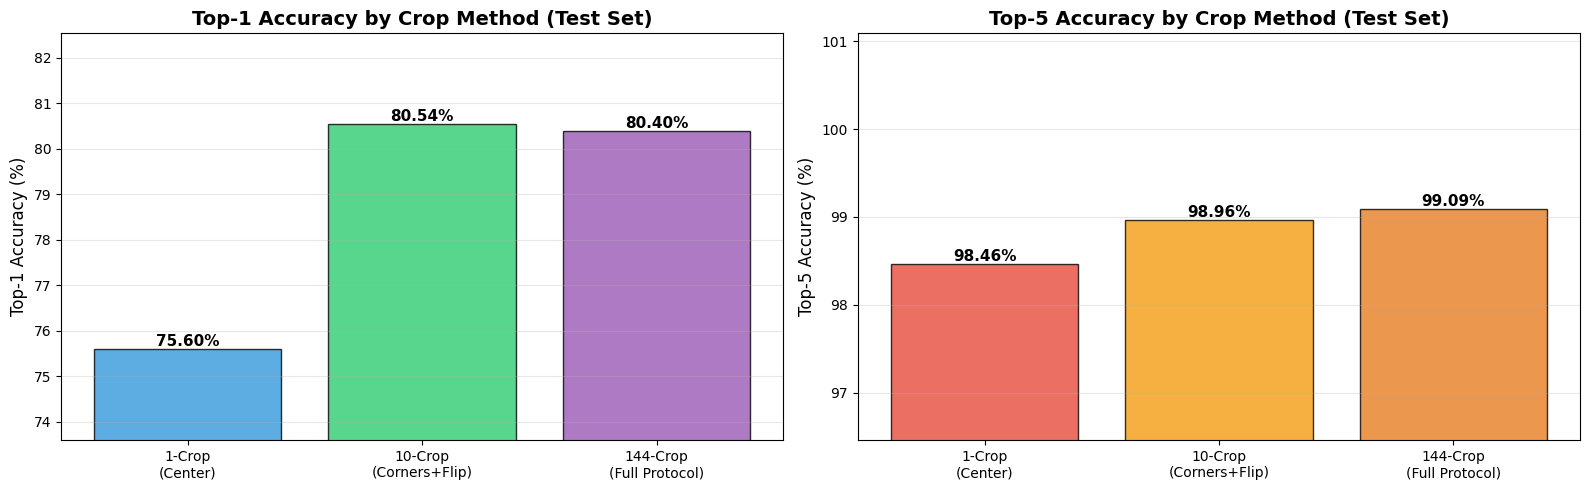


Visualization saved to: ./results/finetune_20251213_224800/test_multicrop_comparison.png


In [54]:
# Visualize multi-crop comparison
crop_types = ['1-Crop\n(Center)', '10-Crop\n(Corners+Flip)', '144-Crop\n(Full Protocol)']
top1_scores = [top1_1crop, top1_10crop, top1_144crop]
top5_scores = [top5_1crop, top5_10crop, top5_144crop]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Top-1 accuracy comparison
bars1 = ax1.bar(crop_types, top1_scores, color=['#3498db', '#2ecc71', '#9b59b6'], alpha=0.8, edgecolor='black')
ax1.set_ylabel('Top-1 Accuracy (%)', fontsize=12)
ax1.set_title('Top-1 Accuracy by Crop Method (Test Set)', fontsize=14, fontweight='bold')
ax1.set_ylim([min(top1_scores) - 2, max(top1_scores) + 2])
ax1.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.2f}%', ha='center', va='bottom', fontsize=11, fontweight='bold')

# Top-5 accuracy comparison
bars2 = ax2.bar(crop_types, top5_scores, color=['#e74c3c', '#f39c12', '#e67e22'], alpha=0.8, edgecolor='black')
ax2.set_ylabel('Top-5 Accuracy (%)', fontsize=12)
ax2.set_title('Top-5 Accuracy by Crop Method (Test Set)', fontsize=14, fontweight='bold')
ax2.set_ylim([min(top5_scores) - 2, max(top5_scores) + 2])
ax2.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.2f}%', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(save_path, 'test_multicrop_comparison.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f"\nVisualization saved to: {os.path.join(save_path, 'test_multicrop_comparison.png')}")

### 9.1 Complete Performance Overview

In [56]:
# Create comprehensive performance visualization
fig = plt.figure(figsize=(16, 10))

# 1. Training History (Top-1 Accuracy)
ax1 = plt.subplot(2, 3, 1)
ax1.plot(range(1, len(history['train_acc'])+1), history['train_acc'],
         'b-o', label='Train', linewidth=2, markersize=6)
ax1.plot(range(1, len(history['val_acc'])+1), history['val_acc'],
         'r-s', label='Validation', linewidth=2, markersize=6)
ax1.axhline(y=top1_1crop, color='g', linestyle='--', linewidth=2, label=f'Test (1-crop): {top1_1crop:.2f}%')
ax1.axhline(y=top1_10crop, color='purple', linestyle='--', linewidth=2, label=f'Test (10-crop): {top1_10crop:.2f}%')
ax1.axhline(y=top1_144crop, color='orange', linestyle=':', linewidth=2, label=f'Test (144-crop): {top1_144crop:.2f}%')
ax1.set_xlabel('Epoch', fontsize=11)
ax1.set_ylabel('Top-1 Accuracy (%)', fontsize=11)
ax1.set_title('Top-1 Accuracy: Train vs Val vs Test', fontsize=12, fontweight='bold')
ax1.legend(fontsize=8)
ax1.grid(True, alpha=0.3)

# 2. Training History (Loss)
ax2 = plt.subplot(2, 3, 2)
ax2.plot(range(1, len(history['train_loss'])+1), history['train_loss'],
         'b-o', label='Train Loss', linewidth=2, markersize=6)
ax2.plot(range(1, len(history['val_loss'])+1), history['val_loss'],
         'r-s', label='Val Loss', linewidth=2, markersize=6)
ax2.axhline(y=loss_1crop, color='g', linestyle='--', linewidth=2, label=f'Test Loss: {loss_1crop:.4f}')
ax2.set_xlabel('Epoch', fontsize=11)
ax2.set_ylabel('Loss', fontsize=11)
ax2.set_title('Loss Over Training', fontsize=12, fontweight='bold')
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3)

# 3. Top-5 Accuracy Comparison
ax3 = plt.subplot(2, 3, 3)
categories = ['Train\n(Final)', 'Val\n(Final)', 'Test\n(1-crop)', 'Test\n(10-crop)', 'Test\n(144-crop)']
top5_values = [100.0, history['val_top5_acc'][-1], top5_1crop, top5_10crop, top5_144crop]
colors = ['#3498db', '#e74c3c', '#2ecc71', '#9b59b6', '#e67e22']
bars = ax3.bar(categories, top5_values, color=colors, alpha=0.8, edgecolor='black')
ax3.set_ylabel('Top-5 Accuracy (%)', fontsize=11)
ax3.set_title('Top-5 Accuracy Comparison', fontsize=12, fontweight='bold')
ax3.set_ylim([min(top5_values) - 5, 100])
ax3.grid(True, alpha=0.3, axis='y')
plt.setp(ax3.get_xticklabels(), rotation=20, ha='right', fontsize=9)
for bar in bars:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}%', ha='center', va='bottom', fontsize=8, fontweight='bold')

# 4. Test Set: Multi-crop Impact
ax4 = plt.subplot(2, 3, 4)
crop_methods = ['1-Crop', '10-Crop', '144-Crop']
improvements = [0, top1_10crop - top1_1crop, top1_144crop - top1_1crop]
colors_imp = ['#95a5a6', '#27ae60', '#16a085']
bars = ax4.bar(crop_methods, improvements, color=colors_imp, alpha=0.8, edgecolor='black')
ax4.set_ylabel('Accuracy Improvement (%)', fontsize=11)
ax4.set_title('Multi-Crop Benefit (vs 1-crop)', fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='y')
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
            f'+{height:.2f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

# 5. Final Performance Summary (Bar chart)
ax5 = plt.subplot(2, 3, 5)
datasets = ['Train\n(Final)', 'Val\n(Best)', 'Test\n(1-crop)', 'Test\n(10-crop)', 'Test\n(144-crop)']
accuracies = [history['train_acc'][-1], best_val_acc, top1_1crop, top1_10crop, top1_144crop]
colors_final = ['#3498db', '#e74c3c', '#2ecc71', '#9b59b6', '#e67e22']
bars = ax5.bar(datasets, accuracies, color=colors_final, alpha=0.8, edgecolor='black')
ax5.set_ylabel('Top-1 Accuracy (%)', fontsize=11)
ax5.set_title('Final Top-1 Accuracy Summary', fontsize=12, fontweight='bold')
ax5.set_ylim([min(accuracies) - 5, max(accuracies) + 5])
ax5.grid(True, alpha=0.3, axis='y')
plt.setp(ax5.get_xticklabels(), rotation=20, ha='right', fontsize=9)
for bar in bars:
    height = bar.get_height()
    ax5.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.2f}%', ha='center', va='bottom', fontsize=8, fontweight='bold')

# 6. Learning Rate Schedule
ax6 = plt.subplot(2, 3, 6)
ax6.plot(range(1, len(history['learning_rates'])+1), history['learning_rates'],
         'g-o', linewidth=2, markersize=6)
ax6.set_xlabel('Epoch', fontsize=11)
ax6.set_ylabel('Learning Rate', fontsize=11)
ax6.set_title('Learning Rate Schedule', fontsize=12, fontweight='bold')
ax6.set_yscale('log')
ax6.grid(True, alpha=0.3)

plt.suptitle('GoogLeNet Fine-tuning - Complete Performance Analysis',
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout(rect=[0, 0, 1, 0.99])
plt.savefig(os.path.join(save_path, 'complete_performance_analysis.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f"\nComplete performance analysis saved to: {os.path.join(save_path, 'complete_performance_analysis.png')}")


Complete performance analysis saved to: ./results/finetune_20251213_224800/complete_performance_analysis.png


### 9.2 Per-Class Accuracy Analysis on Test Set

In [9]:

# CIFAR-10 class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

model.eval()

# For single-crop evaluation (faster)

# Create test loader with simple preprocessing
test_transform_simple = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                       std=[0.229, 0.224, 0.225])
])

from torch.utils.data import Dataset

class TransformedDataset(Dataset):
    def __init__(self, base_dataset, transform):
        self.base_dataset = base_dataset
        self.transform = transform

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx):
        img, label = self.base_dataset[idx]
        if self.transform:
            img = self.transform(img)
        return img, label

test_dataset_transformed = TransformedDataset(test_dataset_raw, test_transform_simple)

test_loader_simple = DataLoader(
    test_dataset_transformed,
    batch_size=config['batch_size'],
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

In [ ]:
# Compute per-class accuracy on test set using the best model
print("Computing per-class accuracy on test set...")

# Initialize counters for each class
class_correct = [0] * len(class_names)
class_total = [0] * len(class_names)

with torch.no_grad():
    for inputs, labels in test_loader_simple:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)

        # Update per-class counters
        for i in range(labels.size(0)):
            label = labels[i].item()
            class_correct[label] += (predicted[i] == labels[i]).item()
            class_total[label] += 1

# Calculate per-class accuracies
class_accuracies = [100.0 * class_correct[i] / class_total[i]
                    for i in range(len(class_names))]

# Print per-class results
print("\nPer-Class Accuracy (Test Set):")
print("-" * 50)
for i, class_name in enumerate(class_names):
    print(f"  {class_name:12s}: {class_accuracies[i]:6.2f}% ({class_correct[i]}/{class_total[i]})")
print("-" * 50)
print(f"  Overall:       {100.0 * sum(class_correct) / sum(class_total):6.2f}%")

# Visualize per-class accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Bar chart
colors_class = plt.cm.tab10(range(len(class_names)))
bars = ax1.bar(range(len(class_names)), class_accuracies, color=colors_class, alpha=0.8, edgecolor='black')
ax1.set_xticks(range(len(class_names)))
ax1.set_xticklabels(class_names, rotation=45, ha='right')
ax1.set_ylabel('Accuracy (%)', fontsize=12)
ax1.set_title('Per-Class Accuracy on Test Set', fontsize=14, fontweight='bold')
ax1.axhline(y=np.mean(class_accuracies), color='r', linestyle='--',
            linewidth=2, label=f'Mean: {np.mean(class_accuracies):.2f}%')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}%', ha='center', va='bottom', fontsize=9)

# Sort by accuracy for better visualization
sorted_indices = np.argsort(class_accuracies)[::-1]
sorted_classes = [class_names[i] for i in sorted_indices]
sorted_accuracies = [class_accuracies[i] for i in sorted_indices]

bars2 = ax2.barh(range(len(sorted_classes)), sorted_accuracies,
                 color=[colors_class[sorted_indices[i]] for i in range(len(sorted_classes))],
                 alpha=0.8, edgecolor='black')
ax2.set_yticks(range(len(sorted_classes)))
ax2.set_yticklabels(sorted_classes)
ax2.set_xlabel('Accuracy (%)', fontsize=12)
ax2.set_title('Per-Class Accuracy (Sorted)', fontsize=14, fontweight='bold')
ax2.axvline(x=np.mean(class_accuracies), color='r', linestyle='--',
            linewidth=2, label=f'Mean: {np.mean(class_accuracies):.2f}%')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3, axis='x')

# Add value labels
for i, bar in enumerate(bars2):
    width = bar.get_width()
    ax2.text(width, bar.get_y() + bar.get_height()/2.,
            f' {width:.1f}%', ha='left', va='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(save_path, 'per_class_accuracy.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f"\nPer-class accuracy visualization saved to: {os.path.join(save_path, 'per_class_accuracy.png')}")

Computing per-class accuracy on test set...



Per-Class Accuracy (Test Set):
--------------------------------------------------
  airplane    :  74.80% (748/1000)
  automobile  :  85.00% (850/1000)
  bird        :  68.60% (686/1000)
  cat         :  52.70% (527/1000)
  deer        :  64.60% (646/1000)
  dog         :  75.20% (752/1000)
  frog        :  84.60% (846/1000)
  horse       :  81.90% (819/1000)
  ship        :  81.00% (810/1000)
  truck       :  87.00% (870/1000)
--------------------------------------------------
  Overall:        75.54%



✓ Per-class accuracy visualization saved to: ./results/finetune_20251214_170838/per_class_accuracy.png


### 9.3 Confusion Matrix Analysis

Computing confusion matrix on test set...


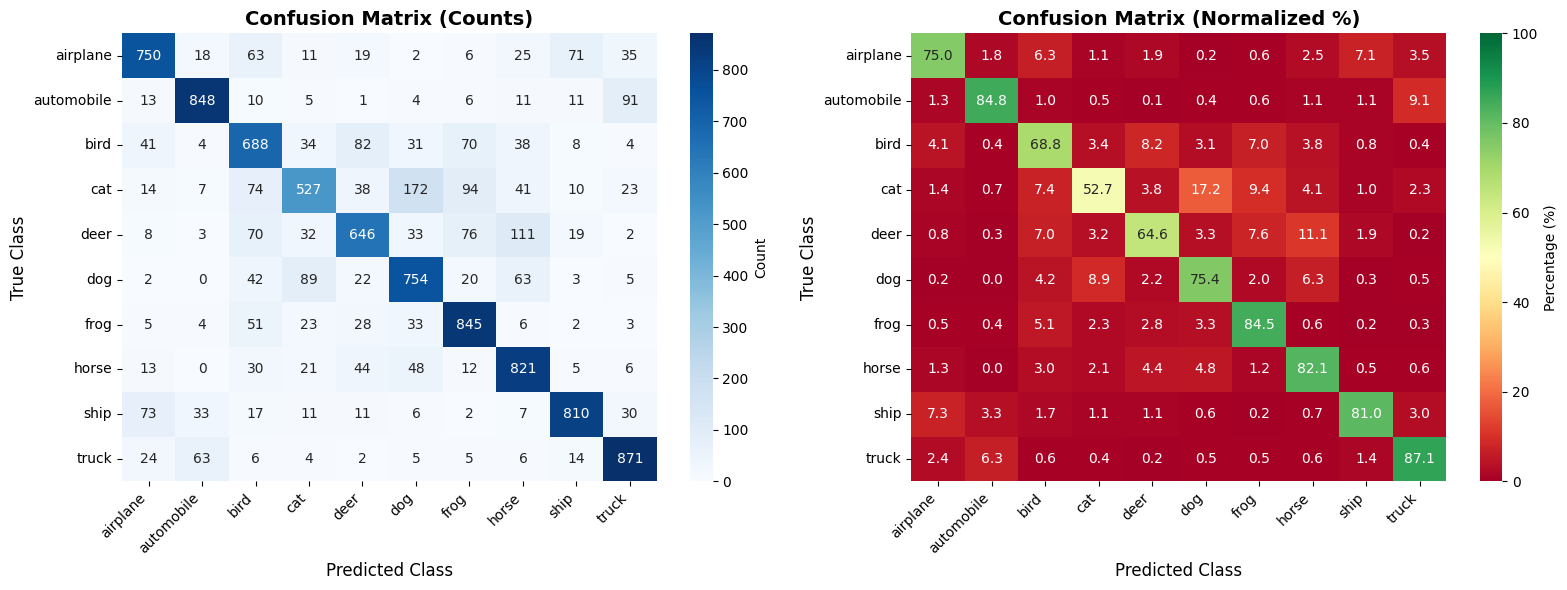


Most Confused Class Pairs:
------------------------------------------------------------
  1. cat          / dog         : 172 times (17.2% of cat samples)
  2. deer         / horse       : 111 times (11.1% of deer samples)
  3. cat          / frog        :  94 times (9.4% of cat samples)
  4. automobile   / truck       :  91 times (9.1% of automobile samples)
  5. dog          / cat         :  89 times (8.9% of dog samples)

Confusion matrix saved to: ./results/finetune_20251213_224800/confusion_matrix.png


In [57]:
# Compute confusion matrix
print("Computing confusion matrix on test set...")

from sklearn.metrics import confusion_matrix
import seaborn as sns

# Collect all predictions and labels
all_predictions = []
all_labels = []

model.eval()
with torch.no_grad():
    for inputs, labels in test_loader_simple:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)

        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_predictions)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Plot confusion matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Raw confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            ax=ax1, cbar_kws={'label': 'Count'})
ax1.set_xlabel('Predicted Class', fontsize=12)
ax1.set_ylabel('True Class', fontsize=12)
ax1.set_title('Confusion Matrix (Counts)', fontsize=14, fontweight='bold')
plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')
plt.setp(ax1.get_yticklabels(), rotation=0)

# Normalized confusion matrix (percentages)
sns.heatmap(cm_normalized, annot=True, fmt='.1f', cmap='RdYlGn',
            xticklabels=class_names, yticklabels=class_names,
            ax=ax2, cbar_kws={'label': 'Percentage (%)'}, vmin=0, vmax=100)
ax2.set_xlabel('Predicted Class', fontsize=12)
ax2.set_ylabel('True Class', fontsize=12)
ax2.set_title('Confusion Matrix (Normalized %)', fontsize=14, fontweight='bold')
plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')
plt.setp(ax2.get_yticklabels(), rotation=0)

plt.tight_layout()
plt.savefig(os.path.join(save_path, 'confusion_matrix.png'), dpi=150, bbox_inches='tight')
plt.show()

# Find most confused pairs
print("\nMost Confused Class Pairs:")
print("-" * 60)
confused_pairs = []
for i in range(len(class_names)):
    for j in range(len(class_names)):
        if i != j:  # Not diagonal
            confused_pairs.append((i, j, cm[i, j]))

# Sort by confusion count
confused_pairs.sort(key=lambda x: x[2], reverse=True)

# Show top 5 most confused pairs
for rank, (true_class, pred_class, count) in enumerate(confused_pairs[:5], 1):
    pct = 100.0 * count / cm[true_class].sum()
    print(f"  {rank}. {class_names[true_class]:12s} / {class_names[pred_class]:12s}: "
          f"{count:3d} times ({pct:.1f}% of {class_names[true_class]} samples)")

print(f"\nConfusion matrix saved to: {os.path.join(save_path, 'confusion_matrix.png')}")

### 9.4 Sample Predictions Visualization 

Generating sample predictions visualization...


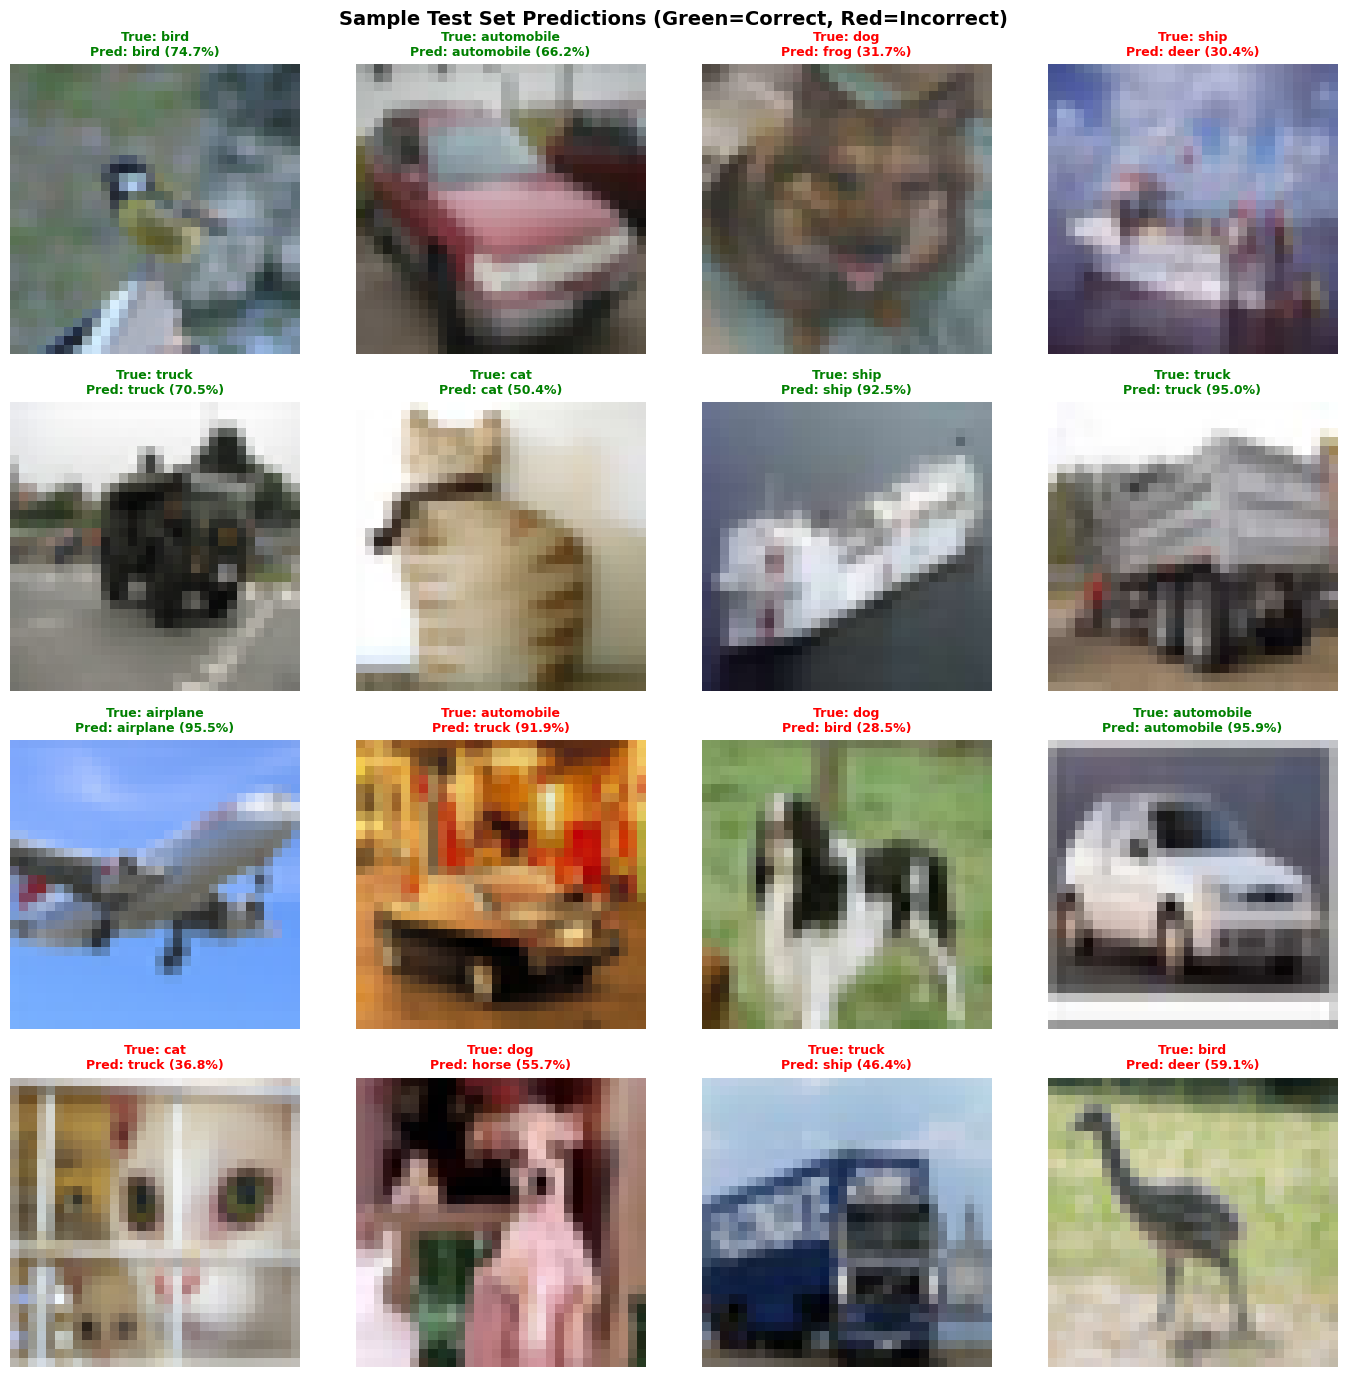

Sample predictions saved to: ./results/finetune_20251213_224800/sample_predictions.png


In [59]:
# Visualize sample predictions (correct and incorrect)
print("Generating sample predictions visualization...")

# Get some random test samples
num_samples = 16
np.random.seed(42)
sample_indices = np.random.choice(len(test_dataset_raw), num_samples, replace=False)

fig, axes = plt.subplots(4, 4, figsize=(14, 14))
axes = axes.ravel()

for idx, sample_idx in enumerate(sample_indices):
    # Get image and true label
    img, true_label = test_dataset_raw[sample_idx]

    # Preprocess for model
    img_tensor = test_transform_simple(img).unsqueeze(0).to(device)

    # Get prediction
    model.eval()
    with torch.no_grad():
        output = model(img_tensor)
        probabilities = torch.nn.functional.softmax(output, dim=1)
        top_prob, top_class = probabilities.topk(1, dim=1)
        predicted_label = top_class.item()
        confidence = top_prob.item() * 100

    # Display image
    axes[idx].imshow(img)
    axes[idx].axis('off')

    # Color code: green for correct, red for incorrect
    is_correct = (predicted_label == true_label)
    color = 'green' if is_correct else 'red'

    # Create title
    title = f"True: {class_names[true_label]}\n"
    title += f"Pred: {class_names[predicted_label]} ({confidence:.1f}%)"

    axes[idx].set_title(title, fontsize=9, color=color, fontweight='bold')

plt.suptitle('Sample Test Set Predictions (Green=Correct, Red=Incorrect)',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(save_path, 'sample_predictions.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f"Sample predictions saved to: {os.path.join(save_path, 'sample_predictions.png')}")

## 11. Adversarial Robustness Evaluation

Evaluate the model's robustness against adversarial attacks using FGSM and PGD attacks with different perturbation strengths.
### 11.1 Setup for Adversarial Attacks


In [11]:
# Import attack functions
from tools.attacks import fgsm_attack, pgd_attack, evaluate_robustness

# Create a dataloader for robustness evaluation
# Using a subset for faster evaluation (first 1000 samples)
from torch.utils.data import Subset

# Use the transformed test dataset (with preprocessing)
test_subset_indices = list(range(min(1000, len(test_dataset_transformed))))
test_subset = Subset(test_dataset_transformed, test_subset_indices)

robustness_loader = DataLoader(
    test_subset,
    batch_size=64,  
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

print(f"Robustness evaluation will use {len(test_subset)} test samples")
print(f"Batch size: 64")
print(f"Number of batches: {len(robustness_loader)}")

# Ensure model is on device and in eval mode
model = model.to(device)
model.eval()
print(f"\nModel ready on device: {device}")

Robustness evaluation will use 1000 test samples
Batch size: 64
Number of batches: 16

Model ready on device: cpu


### 11.2 FGSM Attack Evaluation

Fast Gradient Sign Method with different epsilon values (perturbation strengths).

In [10]:
# FGSM attack with different epsilon values
print("="*70)
print("FGSM (Fast Gradient Sign Method) Attack Evaluation")
print("="*70)

# Test different perturbation strengths
epsilon_values = [0.0, 2/255, 4/255, 8/255, 16/255, 32/255]
fgsm_results = []

for eps in epsilon_values:
    print(f"\nEvaluating FGSM with epsilon = {eps:.4f} ({eps*255:.1f}/255)...")
    
    # Create attack function with fixed epsilon
    def fgsm_eps(model, images, labels):
        return fgsm_attack(model, images, labels, epsilon=eps)
    
    # Evaluate robustness
    results = evaluate_robustness(
        model=model,
        dataloader=robustness_loader,
        attack_fn=fgsm_eps,
        device=device
    )
    
    results['epsilon'] = eps
    fgsm_results.append(results)
    
    print(f"  Clean Accuracy:        {results['clean_accuracy']:.2f}%")
    print(f"  Robust Accuracy:       {results['robust_accuracy']:.2f}%")
    print(f"  Attack Success Rate:   {results['attack_success_rate']:.2f}%")
    print(f"  Accuracy Drop:         {results['clean_accuracy'] - results['robust_accuracy']:.2f}%")

print("\n" + "="*70)
print("FGSM Evaluation Complete!")
print("="*70)

FGSM (Fast Gradient Sign Method) Attack Evaluation

Evaluating FGSM with epsilon = 0.0000 (0.0/255)...
  Clean Accuracy:        73.70%
  Robust Accuracy:       73.70%
  Attack Success Rate:   0.00%
  Accuracy Drop:         0.00%

Evaluating FGSM with epsilon = 0.0078 (2.0/255)...
  Clean Accuracy:        73.70%
  Robust Accuracy:       6.00%
  Attack Success Rate:   91.86%
  Accuracy Drop:         67.70%

Evaluating FGSM with epsilon = 0.0157 (4.0/255)...
  Clean Accuracy:        73.70%
  Robust Accuracy:       12.50%
  Attack Success Rate:   83.04%
  Accuracy Drop:         61.20%

Evaluating FGSM with epsilon = 0.0314 (8.0/255)...
  Clean Accuracy:        73.70%
  Robust Accuracy:       24.40%
  Attack Success Rate:   66.89%
  Accuracy Drop:         49.30%

Evaluating FGSM with epsilon = 0.0627 (16.0/255)...
  Clean Accuracy:        73.70%
  Robust Accuracy:       24.00%
  Attack Success Rate:   67.44%
  Accuracy Drop:         49.70%

Evaluating FGSM with epsilon = 0.1255 (32.0/255)..

### 11.3 PGD Attack Evaluation

Stronger iterative attack method.

In [11]:
# PGD attack with different epsilon values
print("="*70)
print("PGD (Projected Gradient Descent) Attack Evaluation")
print("="*70)

# PGD parameters
pgd_steps = 10  # Number of attack iterations
pgd_alpha = 2/255  # Step size per iteration

# Test different perturbation strengths
epsilon_values_pgd = [0.0, 2/255, 4/255, 8/255, 16/255]
pgd_results = []

for eps in epsilon_values_pgd:
    print(f"\nEvaluating PGD with epsilon = {eps:.4f} ({eps*255:.1f}/255)...")
    print(f"  PGD steps: {pgd_steps}, alpha: {pgd_alpha:.4f}")
    
    # Create attack function with fixed parameters
    def pgd_eps(model, images, labels):
        return pgd_attack(
            model, images, labels, 
            epsilon=eps, 
            alpha=min(pgd_alpha, eps/4),  # alpha should be smaller than epsilon
            num_steps=pgd_steps
        )
    
    # Evaluate robustness
    results = evaluate_robustness(
        model=model,
        dataloader=robustness_loader,
        attack_fn=pgd_eps,
        device=device
    )
    
    results['epsilon'] = eps
    pgd_results.append(results)
    
    print(f"  Clean Accuracy:        {results['clean_accuracy']:.2f}%")
    print(f"  Robust Accuracy:       {results['robust_accuracy']:.2f}%")
    print(f"  Attack Success Rate:   {results['attack_success_rate']:.2f}%")
    print(f"  Accuracy Drop:         {results['clean_accuracy'] - results['robust_accuracy']:.2f}%")

print("\n" + "="*70)
print("PGD Evaluation Complete!")
print("="*70)

PGD (Projected Gradient Descent) Attack Evaluation

Evaluating PGD with epsilon = 0.0000 (0.0/255)...
  PGD steps: 10, alpha: 0.0078
  Clean Accuracy:        73.70%
  Robust Accuracy:       73.70%
  Attack Success Rate:   0.00%
  Accuracy Drop:         0.00%

Evaluating PGD with epsilon = 0.0078 (2.0/255)...
  PGD steps: 10, alpha: 0.0078
  Clean Accuracy:        73.70%
  Robust Accuracy:       0.00%
  Attack Success Rate:   100.00%
  Accuracy Drop:         73.70%

Evaluating PGD with epsilon = 0.0157 (4.0/255)...
  PGD steps: 10, alpha: 0.0078
  Clean Accuracy:        73.70%
  Robust Accuracy:       0.00%
  Attack Success Rate:   100.00%
  Accuracy Drop:         73.70%

Evaluating PGD with epsilon = 0.0314 (8.0/255)...
  PGD steps: 10, alpha: 0.0078
  Clean Accuracy:        73.70%
  Robust Accuracy:       0.00%
  Attack Success Rate:   100.00%
  Accuracy Drop:         73.70%

Evaluating PGD with epsilon = 0.0627 (16.0/255)...
  PGD steps: 10, alpha: 0.0078
  Clean Accuracy:        73.

### 11.4 Visualize Adversarial Examples

Clean and adversarial images side-by-side to understand the attacks visually.

Generating adversarial examples visualization...


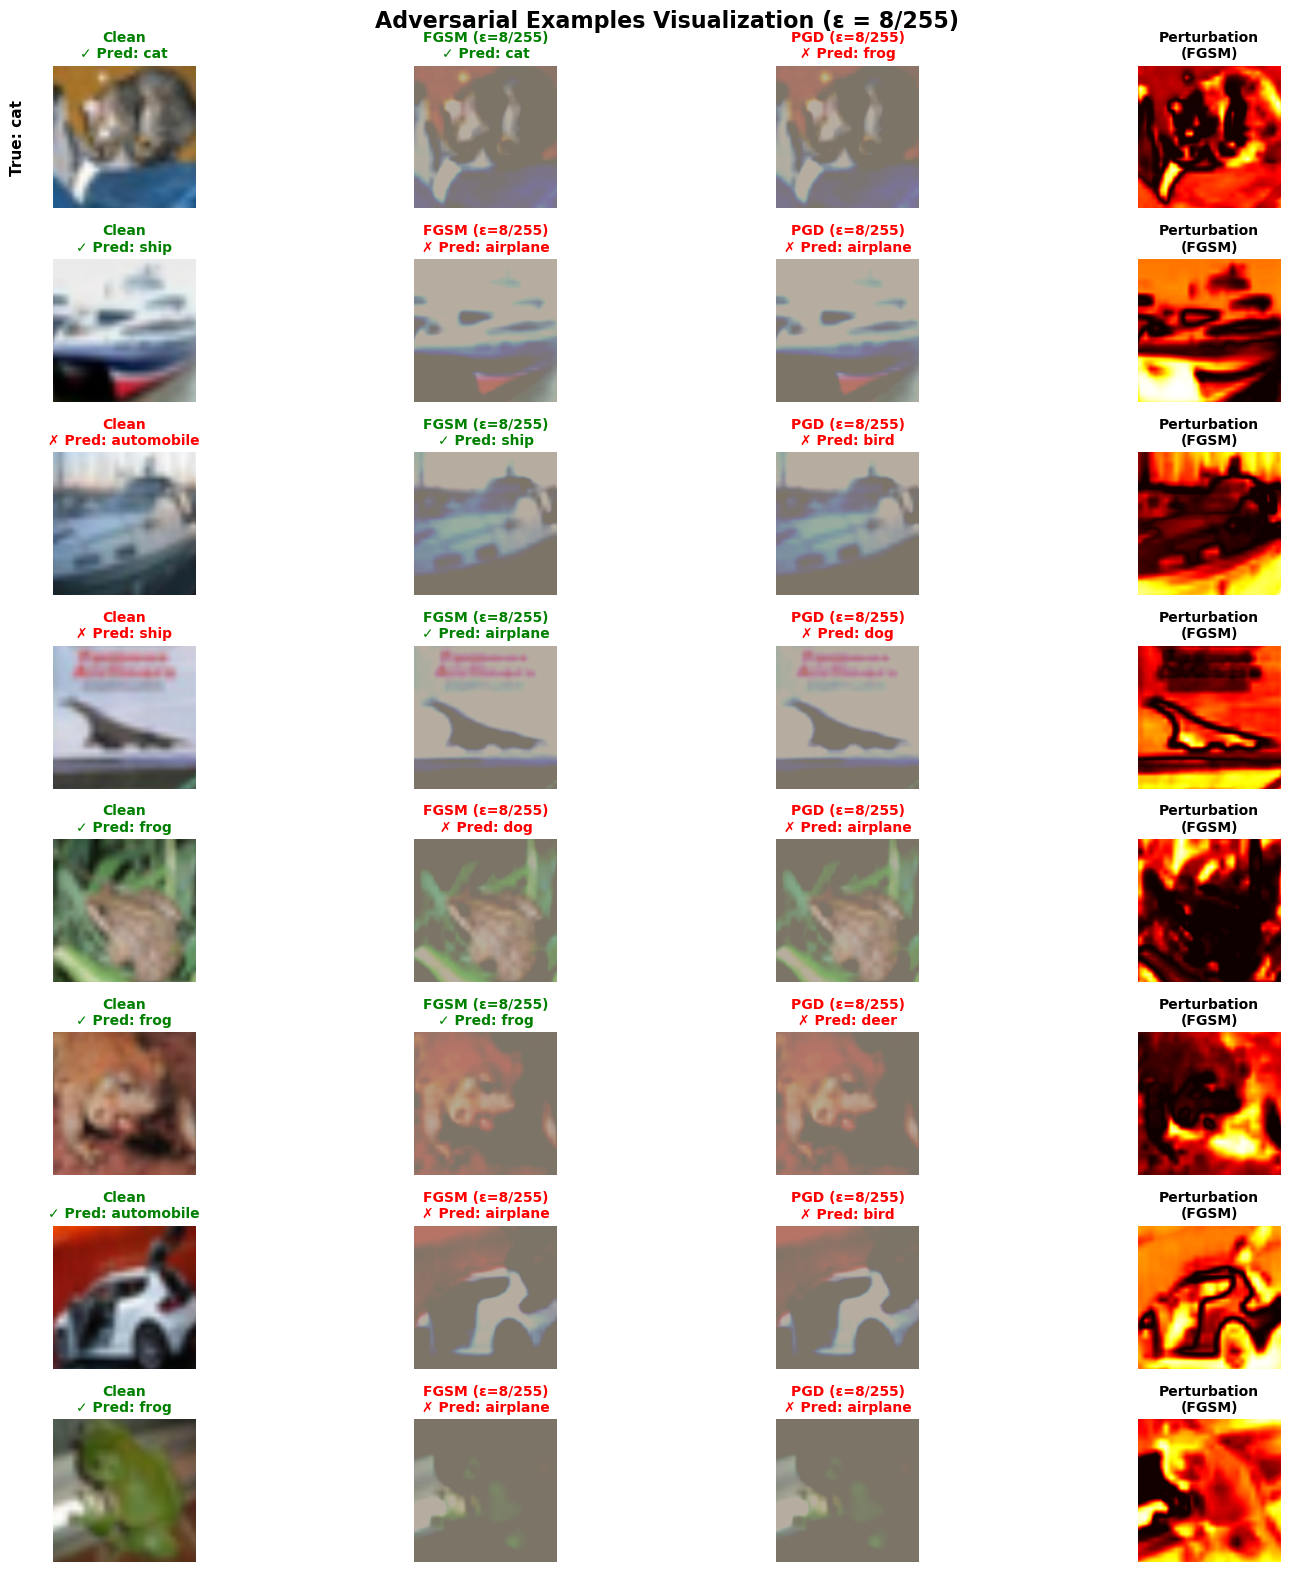

✓ Adversarial examples saved to: ./results/finetune_20251214_032407/adversarial_examples.png

Summary for displayed examples:
  Clean predictions correct: 6/8
  FGSM predictions correct:  4/8
  PGD predictions correct:   0/8


In [13]:
# Visualize adversarial examples
print("Generating adversarial examples visualization...")

# Get a batch of test images
test_iter = iter(robustness_loader)
images_clean, labels = next(test_iter)
images_clean, labels = images_clean.to(device), labels.to(device)

# Generate adversarial examples with different methods
epsilon_vis = 8/255

# FGSM attack
images_fgsm = fgsm_attack(model, images_clean, labels, epsilon=epsilon_vis)

# PGD attack
images_pgd = pgd_attack(model, images_clean, labels, 
                        epsilon=epsilon_vis, alpha=2/255, num_steps=10)

# Get predictions
model.eval()
with torch.no_grad():
    outputs_clean = model(images_clean)
    outputs_fgsm = model(images_fgsm)
    outputs_pgd = model(images_pgd)
    
    if isinstance(outputs_clean, tuple):
        outputs_clean = outputs_clean[0]
        outputs_fgsm = outputs_fgsm[0]
        outputs_pgd = outputs_pgd[0]
    
    pred_clean = outputs_clean.argmax(1)
    pred_fgsm = outputs_fgsm.argmax(1)
    pred_pgd = outputs_pgd.argmax(1)

# Denormalize images for visualization
mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1).to(device)
std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1).to(device)

def denormalize(img):
    return torch.clamp(img * std + mean, 0, 1)

# Select 8 examples to display
num_examples = 8
fig, axes = plt.subplots(num_examples, 4, figsize=(16, 2*num_examples))

for i in range(num_examples):
    # Clean image
    img_clean = denormalize(images_clean[i]).cpu().permute(1, 2, 0).numpy()
    axes[i, 0].imshow(img_clean)
    axes[i, 0].axis('off')
    correct_clean = '✓' if pred_clean[i] == labels[i] else '✗'
    axes[i, 0].set_title(f'Clean\n{correct_clean} Pred: {class_names[pred_clean[i]]}', 
                         fontsize=10, color='green' if correct_clean == '✓' else 'red',
                         fontweight='bold')
    
    # FGSM adversarial
    img_fgsm = denormalize(images_fgsm[i]).cpu().permute(1, 2, 0).numpy()
    axes[i, 1].imshow(img_fgsm)
    axes[i, 1].axis('off')
    correct_fgsm = '✓' if pred_fgsm[i] == labels[i] else '✗'
    axes[i, 1].set_title(f'FGSM (ε=8/255)\n{correct_fgsm} Pred: {class_names[pred_fgsm[i]]}', 
                         fontsize=10, color='green' if correct_fgsm == '✓' else 'red',
                         fontweight='bold')
    
    # PGD adversarial
    img_pgd = denormalize(images_pgd[i]).cpu().permute(1, 2, 0).numpy()
    axes[i, 2].imshow(img_pgd)
    axes[i, 2].axis('off')
    correct_pgd = '✓' if pred_pgd[i] == labels[i] else '✗'
    axes[i, 2].set_title(f'PGD (ε=8/255)\n{correct_pgd} Pred: {class_names[pred_pgd[i]]}', 
                         fontsize=10, color='green' if correct_pgd == '✓' else 'red',
                         fontweight='bold')
    
    # Perturbation visualization (amplified for visibility)
    perturbation_fgsm = (images_fgsm[i] - images_clean[i]).abs()
    perturbation_vis = perturbation_fgsm.mean(dim=0).cpu().numpy()
    perturbation_vis = (perturbation_vis - perturbation_vis.min()) / (perturbation_vis.max() - perturbation_vis.min() + 1e-8)
    axes[i, 3].imshow(perturbation_vis, cmap='hot')
    axes[i, 3].axis('off')
    axes[i, 3].set_title(f'Perturbation\n(FGSM)', fontsize=10, fontweight='bold')
    
    # Add true label on the left
    if i == 0:
        axes[i, 0].text(-0.3, 0.5, f'True: {class_names[labels[i]]}', 
                       transform=axes[i, 0].transAxes,
                       fontsize=11, fontweight='bold', va='center', rotation=90)

plt.suptitle(f'Adversarial Examples Visualization (ε = {epsilon_vis*255:.0f}/255)', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(save_path, 'adversarial_examples.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ Adversarial examples saved to: {os.path.join(save_path, 'adversarial_examples.png')}")
print(f"\nSummary for displayed examples:")
print(f"  Clean predictions correct: {(pred_clean[:num_examples] == labels[:num_examples]).sum().item()}/{num_examples}")
print(f"  FGSM predictions correct:  {(pred_fgsm[:num_examples] == labels[:num_examples]).sum().item()}/{num_examples}")
print(f"  PGD predictions correct:   {(pred_pgd[:num_examples] == labels[:num_examples]).sum().item()}/{num_examples}")

## 12. Privacy Analysis: Membership Inference Attack

A **Membership Inference Attack (MIA)** tests whether the model "memorizes" its training data too much, which could constitute a privacy leak.

### 12.1 Prepare Data for the Attack


In [10]:
from tools.privacy import MembershipInferenceAttack, plot_membership_inference_results
from torch.utils.data import Subset
import numpy as np

print("="*70)
print("PREPARING DATA FOR MEMBERSHIP INFERENCE ATTACK")
print("="*70)

# Use a sample of training data as "members"
# Note: train_indices already contains the indices of training data
member_sample_size = 2000
non_member_sample_size = 2000

# Randomly select samples from training set
np.random.seed(42)
member_indices_sample = np.random.choice(
    len(train_dataset), 
    size=member_sample_size, 
    replace=False
)

# Create dataset for members
member_dataset = Subset(full_train_dataset, member_indices_sample)
member_loader = DataLoader(
    member_dataset, 
    batch_size=64, 
    shuffle=False, 
    num_workers=2
)

# Use samples from test set as "non-members"
non_member_indices_sample = np.random.choice(
    len(test_dataset_transformed), 
    size=non_member_sample_size, 
    replace=False
)

non_member_dataset = Subset(test_dataset_transformed, non_member_indices_sample)
non_member_loader = DataLoader(
    non_member_dataset, 
    batch_size=64, 
    shuffle=False, 
    num_workers=2
)

print(f"\nData prepared:")
print(f"   - Members (training set): {len(member_dataset)} samples")
print(f"   - Non-members (test set): {len(non_member_dataset)} samples")
print(f"   - Total for attack: {len(member_dataset) + len(non_member_dataset)} samples")

PREPARING DATA FOR MEMBERSHIP INFERENCE ATTACK

Data prepared:
   - Members (training set): 2000 samples
   - Non-members (test set): 2000 samples
   - Total for attack: 4000 samples


### 12.2 Create and Train the Attack

The attack will extract confidence scores from the model and find the optimal threshold to distinguish members vs non-members.

In [11]:
print("="*70)
print("TRAINING MEMBERSHIP INFERENCE ATTACK")
print("="*70)

# Create the attack
mia_attack = MembershipInferenceAttack()

# Prepare attack data (extract confidence scores)
print("\nExtracting model confidence scores...")
X_attack, y_attack = mia_attack.prepare_attack_data(
    model=model,
    member_loader=member_loader,
    non_member_loader=non_member_loader,
    device=device
)

print(f"   - Features shape: {X_attack.shape}")
print(f"   - Labels shape: {y_attack.shape}")
print(f"   - Members (y=1): {np.sum(y_attack == 1)}")
print(f"   - Non-members (y=0): {np.sum(y_attack == 0)}")

# Analyze confidence distributions
member_confidences = X_attack[y_attack == 1]
non_member_confidences = X_attack[y_attack == 0]

print(f"\nConfidence score statistics:")
print(f"   Members (training):")
print(f"      - Mean: {member_confidences.mean():.4f}")
print(f"      - Median: {np.median(member_confidences):.4f}")
print(f"      - Std: {member_confidences.std():.4f}")
print(f"   Non-members (test):")
print(f"      - Mean: {non_member_confidences.mean():.4f}")
print(f"      - Median: {np.median(non_member_confidences):.4f}")
print(f"      - Std: {non_member_confidences.std():.4f}")

TRAINING MEMBERSHIP INFERENCE ATTACK

Extracting model confidence scores...
   - Features shape: (4000,)
   - Labels shape: (4000,)
   - Members (y=1): 2000
   - Non-members (y=0): 2000

Confidence score statistics:
   Members (training):
      - Mean: 0.6716
      - Median: 0.6882
      - Std: 0.2288
   Non-members (test):
      - Mean: 0.6991
      - Median: 0.7250
      - Std: 0.2229


In [12]:
# Train the attack (find optimal threshold)
print(f"\nSearching for optimal threshold...")
optimal_threshold = mia_attack.train_attack(X_attack, y_attack)

print(f"\nAttack trained successfully!")
print(f"Optimal threshold: {optimal_threshold:.4f}")
print(f"   If confidence ≥ {optimal_threshold:.4f}: Prediction: MEMBER")
print(f"   If confidence < {optimal_threshold:.4f}: Prediction: NON-MEMBER")


Searching for optimal threshold...
Optimal threshold found: 0.9987

Attack trained successfully!
Optimal threshold: 0.9987
   If confidence ≥ 0.9987: Prediction: MEMBER
   If confidence < 0.9987: Prediction: NON-MEMBER


### 12.3 Evaluate the Attack on Test Set


In [13]:
print("="*70)
print("EVALUATING MEMBERSHIP INFERENCE ATTACK")
print("="*70)

# Prepare new samples for testing (different from those used for training)
test_member_size = 1000
test_non_member_size = 1000

# Test members (from training set, but different from those used to train the attack)
remaining_train_indices = [i for i in range(len(train_dataset)) if i not in member_indices_sample]
test_member_indices = np.random.choice(
    remaining_train_indices[:min(len(remaining_train_indices), 5000)], 
    size=test_member_size, 
    replace=False
)

test_member_dataset = Subset(full_train_dataset, test_member_indices)
test_member_loader = DataLoader(
    test_member_dataset, 
    batch_size=64, 
    shuffle=False, 
    num_workers=2
)

# Test non-members (from test set, different from those used for training)
remaining_test_indices = [i for i in range(len(test_dataset_transformed)) if i not in non_member_indices_sample]
test_non_member_indices = np.random.choice(
    remaining_test_indices, 
    size=test_non_member_size, 
    replace=False
)

test_non_member_dataset = Subset(test_dataset_transformed, test_non_member_indices)
test_non_member_loader = DataLoader(
    test_non_member_dataset, 
    batch_size=64, 
    shuffle=False, 
    num_workers=2
)

print(f"\nTest data:")
print(f"   - Members to test: {len(test_member_dataset)}")
print(f"   - Non-members to test: {len(test_non_member_dataset)}")

EVALUATING MEMBERSHIP INFERENCE ATTACK

Test data:
   - Members to test: 1000
   - Non-members to test: 1000


In [14]:
# Evaluate the attack
print(f"\nEvaluating the attack...")
mia_results = mia_attack.evaluate(
    model=model,
    member_loader=test_member_loader,
    non_member_loader=test_non_member_loader,
    device=device
)

# Display results
print("\n" + "="*70)
print("MEMBERSHIP INFERENCE ATTACK RESULTS")
print("="*70)

print(f"\nMain metrics:")
print(f"   - Accuracy: {mia_results['accuracy']:.2%}")
print(f"   - AUC-ROC: {mia_results['auc']:.4f}")

# Calculate other metrics
from sklearn.metrics import confusion_matrix, classification_report

y_true = mia_results['true_labels']
y_pred = mia_results['predictions']

cm = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = cm.ravel()

print(f"\nDetailed metrics:")
print(f"   - True Positives (TP): {tp} (Members correctly identified)")
print(f"   - True Negatives (TN): {tn} (Non-members correctly identified)")
print(f"   - False Positives (FP): {fp} (Non-members identified as members)")
print(f"   - False Negatives (FN): {fn} (Members identified as non-members)")
print(f"   - Precision (Members): {tp/(tp+fp) if (tp+fp)>0 else 0:.2%}")
print(f"   - Recall (Members): {tp/(tp+fn) if (tp+fn)>0 else 0:.2%}")
print(f"   - Precision (Non-members): {tn/(tn+fn) if (tn+fn)>0 else 0:.2%}")


Evaluating the attack...

MEMBERSHIP INFERENCE ATTACK RESULTS

Main metrics:
   - Accuracy: 49.95%
   - AUC-ROC: 0.4636

Detailed metrics:
   - True Positives (TP): 3 (Members correctly identified)
   - True Negatives (TN): 996 (Non-members correctly identified)
   - False Positives (FP): 4 (Non-members identified as members)
   - False Negatives (FN): 997 (Members identified as non-members)
   - Precision (Members): 42.86%
   - Recall (Members): 0.30%
   - Precision (Non-members): 49.97%


### 12.4 Results Visualization

ROC curve and confidence score distributions to better understand the attack.

Plot saved to ./results/finetune_20251215_232300/membership_inference_attack.png


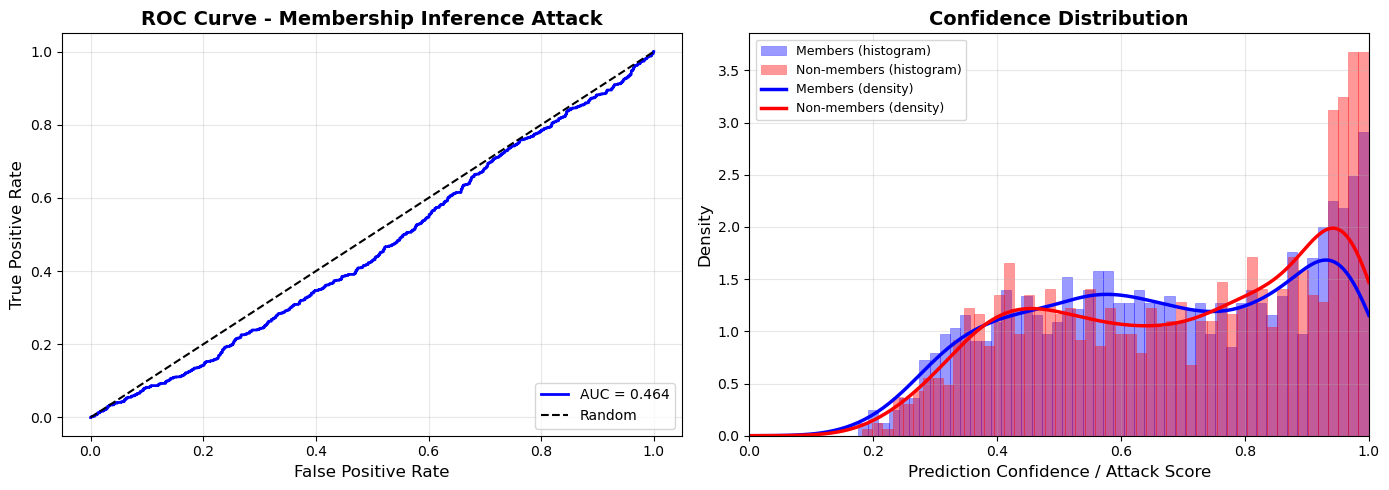

In [15]:
# Visualize results with the provided function
plot_membership_inference_results(
    mia_results, 
    save_path=os.path.join(save_path, 'membership_inference_attack.png')
)

### 12.5 Additional Visualization: Confusion Matrix

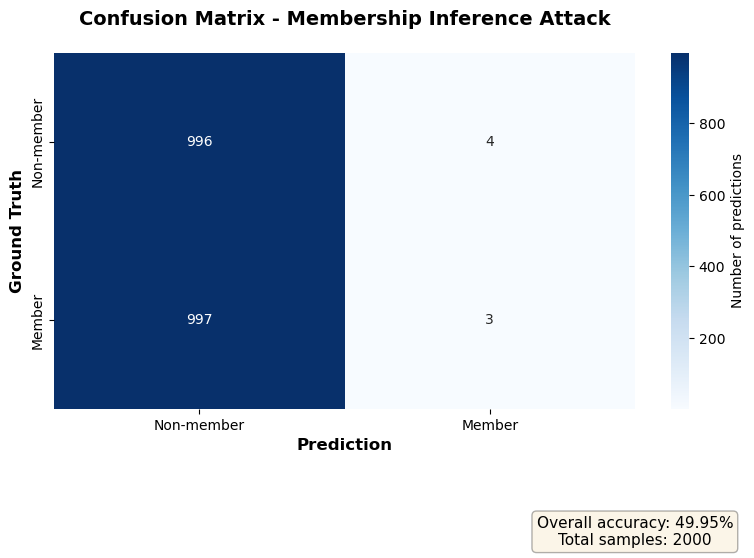


Plots saved in: ./results/finetune_20251215_232300
   - membership_inference_attack.png
   - mia_confusion_matrix.png


In [16]:
import seaborn as sns

# Create figure for confusion matrix
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

# Confusion matrix
cm = confusion_matrix(mia_results['true_labels'], mia_results['predictions'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, 
            xticklabels=['Non-member', 'Member'],
            yticklabels=['Non-member', 'Member'],
            cbar_kws={'label': 'Number of predictions'})

ax.set_xlabel('Prediction', fontsize=12, fontweight='bold')
ax.set_ylabel('Ground Truth', fontsize=12, fontweight='bold')
ax.set_title('Confusion Matrix - Membership Inference Attack', fontsize=14, fontweight='bold', pad=20)

# Add annotations
total = cm.sum()
accuracy = (cm[0, 0] + cm[1, 1]) / total
text = f'Overall accuracy: {accuracy:.2%}\n'
text += f'Total samples: {total}'
ax.text(1, -0.3, text, ha='center', va='top', fontsize=11, 
        transform=ax.transAxes, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.tight_layout()
plt.savefig(os.path.join(save_path, 'mia_confusion_matrix.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"\nPlots saved in: {save_path}")
print(f"   - membership_inference_attack.png")
print(f"   - mia_confusion_matrix.png")

## 9. Explainability (XAI) 

### 9.1 Prepare Samples for Analysis


In [17]:
from tools.xai import GradCAM, OcclusionSensitivity
from tools.xai import extract_features, compute_tsne, visualize_tsne
import importlib
import tools.xai
importlib.reload(tools.xai)

print("="*70)
print("PREPARING SAMPLES FOR XAI")
print("="*70)

# Select some correctly classified images
num_samples = 6
sample_indices = []
sample_images = []
sample_labels = []
sample_predictions = []

model.eval()
with torch.no_grad():
    for i, (images, labels) in enumerate(test_loader_simple):
        if len(sample_indices) >= num_samples:
            break
        
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        if isinstance(outputs, tuple):
            outputs = outputs[0]
        
        _, predicted = outputs.max(1)
        
        # Find correct predictions
        correct_mask = predicted == labels
        for j in range(len(images)):
            if correct_mask[j] and len(sample_indices) < num_samples:
                sample_indices.append(i * len(images) + j)
                sample_images.append(images[j:j+1].cpu())
                sample_labels.append(labels[j].item())
                sample_predictions.append(predicted[j].item())

print(f"\n{len(sample_images)} samples selected for XAI analysis")
print(f"\nSelected classes:")
for i, (label, pred) in enumerate(zip(sample_labels, sample_predictions)):
    print(f"   Image {i+1}: {class_names[label]} (pred: {class_names[pred]})")

PREPARING SAMPLES FOR XAI

6 samples selected for XAI analysis

Selected classes:
   Image 1: cat (pred: cat)
   Image 2: ship (pred: ship)
   Image 3: frog (pred: frog)
   Image 4: frog (pred: frog)
   Image 5: automobile (pred: automobile)
   Image 6: frog (pred: frog)


### 9.2 Method 1: Grad-CAM (Gradient-weighted Class Activation Mapping)

**Principle**: Uses gradients flowing back to a convolutional layer to identify important regions.

**Advantage**: Fast, visually clear, localized on regions of interest.

GRAD-CAM: HEATMAP VISUALIZATION


/home/malak/anaconda3/envs/FSDenv250/lib/python3.11/site-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


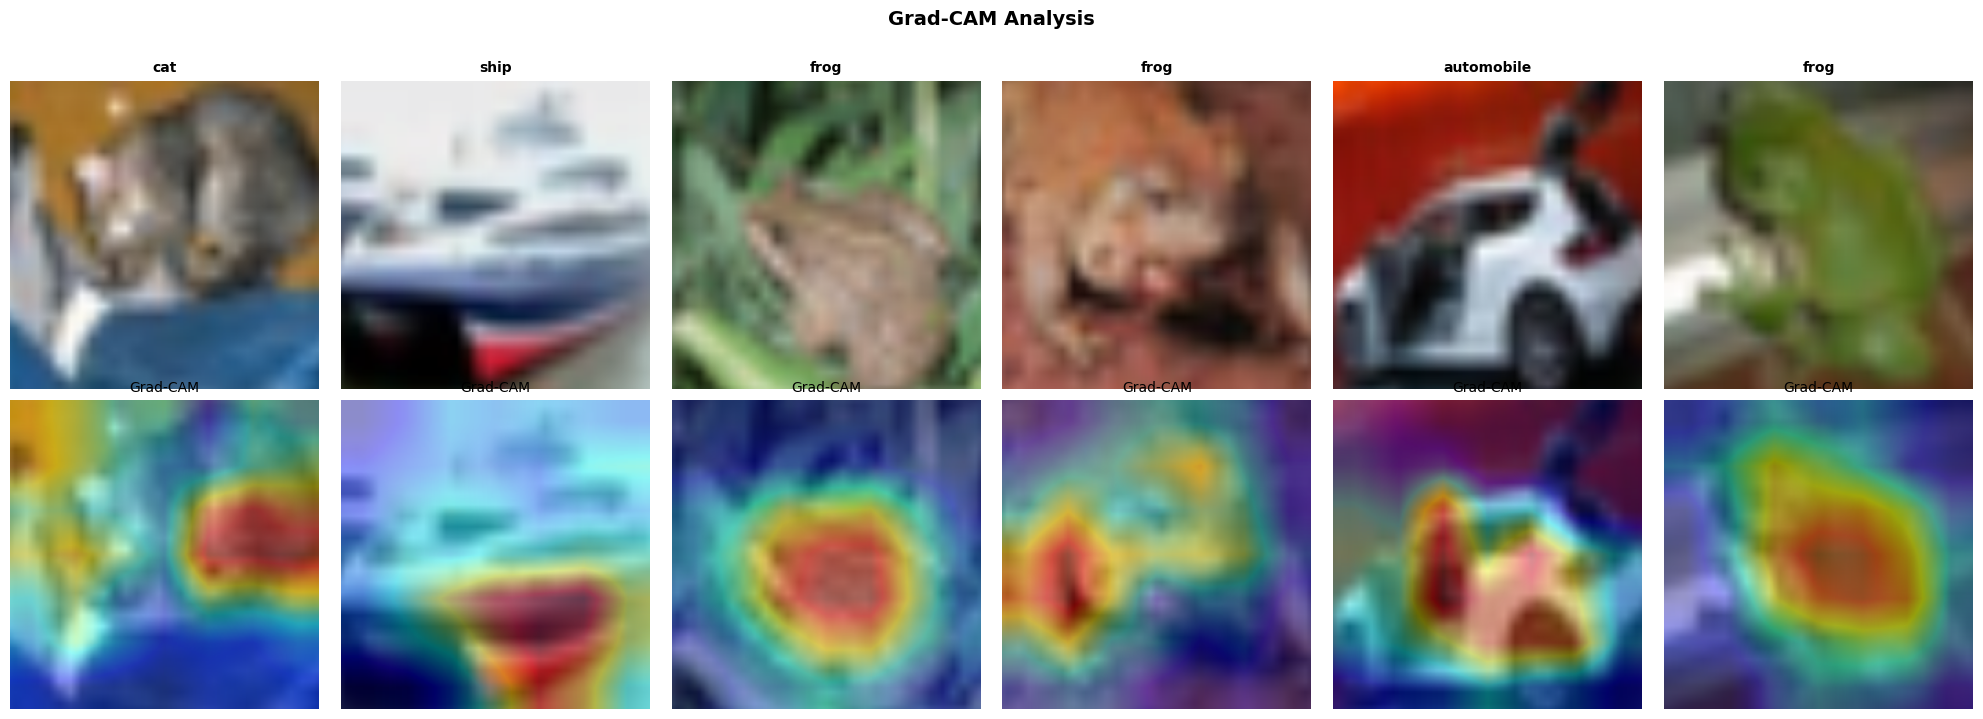


Red/yellow regions indicate the most important areas for the decision


In [18]:
print("="*70)
print("GRAD-CAM: HEATMAP VISUALIZATION")
print("="*70)

# Create Grad-CAM object (use last inception layer)
# For GoogLeNet, use inception5b (last inception layer)
target_layer = model.inception5b
gradcam = GradCAM(model, target_layer)

# Visualize for each sample
fig, axes = plt.subplots(2, num_samples, figsize=(20, 7))

for i, (image, label) in enumerate(zip(sample_images, sample_labels)):
    image_gpu = image.to(device)
    
    # Generate CAM
    cam, pred_class = gradcam.generate_cam(image_gpu, target_class=label)
    
    # Create visualization
    visualization = gradcam.visualize(image[0], cam, original_size=(224, 224), alpha=0.4)
    
    # Original image (denormalized)
    img_display = image[0].detach().cpu().numpy().transpose(1, 2, 0)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img_display = img_display * std + mean
    img_display = np.clip(img_display, 0, 1)
    
    # Display
    axes[0, i].imshow(img_display)
    axes[0, i].set_title(f'{class_names[label]}', fontsize=10, fontweight='bold')
    axes[0, i].axis('off')
    
    axes[1, i].imshow(visualization)
    axes[1, i].set_title(f'Grad-CAM', fontsize=10)
    axes[1, i].axis('off')

plt.suptitle('Grad-CAM Analysis', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(os.path.join(save_path, 'xai_gradcam.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"\nRed/yellow regions indicate the most important areas for the decision")

### 9.3 Method 2: Occlusion Sensitivity

**Principle**: Systematically masks parts of the image and observes confidence drop.

**Advantage**: Very intuitive, model-agnostic. **Disadvantage**: Slower.

OCCLUSION SENSITIVITY: REGION IMPORTANCE
   Image 1/5... Done
   Image 2/5... Done
   Image 3/5... Done
   Image 4/5... Done
   Image 5/5... Done


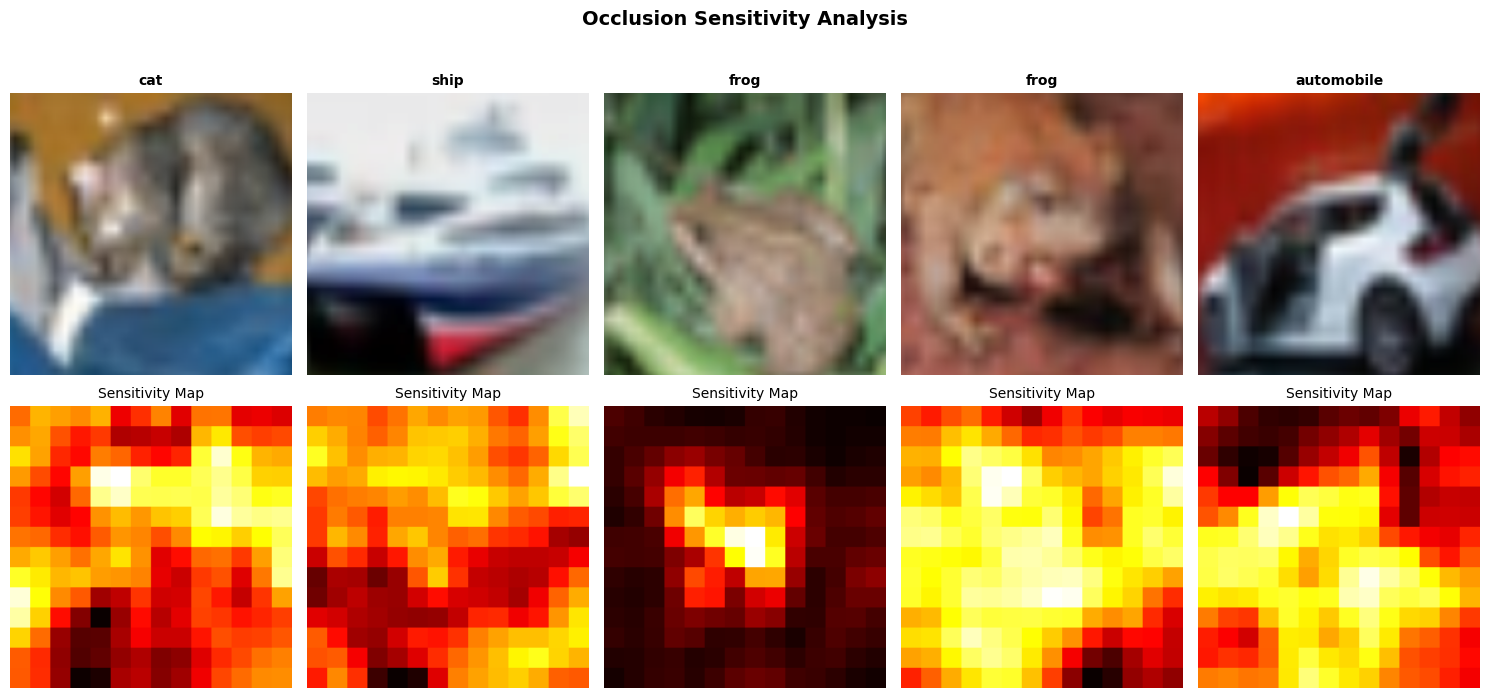


Occlusion Sensitivity completed!
Hot regions (red) are the most critical for prediction


In [19]:
print("="*70)
print("OCCLUSION SENSITIVITY: REGION IMPORTANCE")
print("="*70)

# Create Occlusion object (32x32 patches, stride of 16)
occlusion = OcclusionSensitivity(model, occlusion_size=32, occlusion_stride=16)

# Test on first 5 images 
num_occlusion_samples = 5

fig, axes = plt.subplots(2, num_occlusion_samples, figsize=(15, 7))

for i in range(num_occlusion_samples):
    image = sample_images[i].to(device)
    label = sample_labels[i]
    
    print(f"   Image {i+1}/{num_occlusion_samples}...", end=' ')
    
    # Generate occlusion heatmap
    heatmap, pred_class = occlusion.generate_heatmap(image, target_class=label)
    print("Done")
    
    # Original image
    img_display = sample_images[i][0].detach().cpu().numpy().transpose(1, 2, 0)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img_display = img_display * std + mean
    img_display = np.clip(img_display, 0, 1)
    
    # Display
    axes[0, i].imshow(img_display)
    axes[0, i].set_title(f'{class_names[label]}', fontsize=10, fontweight='bold')
    axes[0, i].axis('off')
    
    # Heatmap with colormap
    im = axes[1, i].imshow(heatmap, cmap='hot', interpolation='bilinear')
    axes[1, i].set_title(f'Sensitivity Map', fontsize=10)
    axes[1, i].axis('off')

plt.suptitle('Occlusion Sensitivity Analysis', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(os.path.join(save_path, 'xai_occlusion.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"\nOcclusion Sensitivity completed!")
print(f"Hot regions (red) are the most critical for prediction")

### 9.4 Method 4: t-SNE Feature Visualization

**Principle**: Extracts features from a deep layer and projects them to 2D with t-SNE.

**Advantage**: Global view of class organization, detects clusters and confusion.

T-SNE FEATURE VISUALIZATION: GLOBAL FEATURE VIEW

Extracting features from inception5b...
   Extracted features: (6400, 1024)
   Labels: (6400,)

Computing t-SNE embedding (may take 1-2 min)...
Computing t-SNE embedding...
[t-SNE] Computing 181 nearest neighbors...
[t-SNE] Indexed 6400 samples in 0.002s...


/home/malak/anaconda3/envs/FSDenv250/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computed neighbors for 6400 samples in 1.145s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6400
[t-SNE] Computed conditional probabilities for sample 2000 / 6400
[t-SNE] Computed conditional probabilities for sample 3000 / 6400
[t-SNE] Computed conditional probabilities for sample 4000 / 6400
[t-SNE] Computed conditional probabilities for sample 5000 / 6400
[t-SNE] Computed conditional probabilities for sample 6000 / 6400
[t-SNE] Computed conditional probabilities for sample 6400 / 6400
[t-SNE] Mean sigma: 2.580752
[t-SNE] KL divergence after 250 iterations with early exaggeration: 80.842003
[t-SNE] KL divergence after 1000 iterations: 2.603848
   Embedding shape: (6400, 2)

Visualizing...
Plot saved to ./results/finetune_20251215_232300/xai_tsne.png


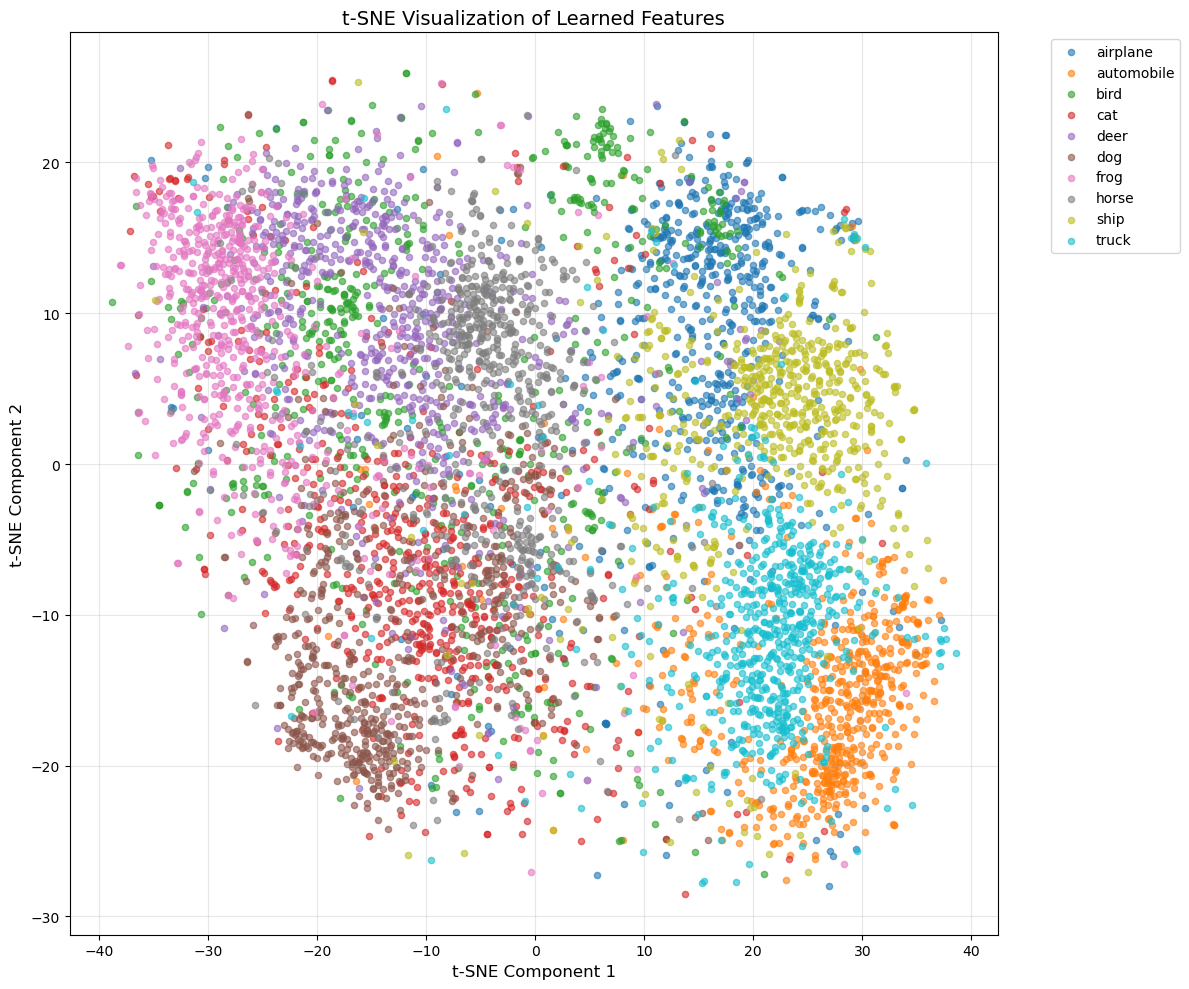


t-SNE completed!
   - Well-separated classes → model discriminates well
   - Overlapping clusters → potential confusion
   - Global structure → learned semantic organization


In [20]:
print("="*70)
print("T-SNE FEATURE VISUALIZATION: GLOBAL FEATURE VIEW")
print("="*70)

# Extract features from last inception layer (inception5b)
print("\nExtracting features from inception5b...")
features, labels_features = extract_features(
    model=model,
    dataloader=test_loader_simple,
    layer_name='inception5b',
    device=device,
    max_batches=50  # Limit to speed up (50 batches ≈ 3200 images)
)

print(f"   Extracted features: {features.shape}")
print(f"   Labels: {labels_features.shape}")

# Compute t-SNE embedding
print(f"\nComputing t-SNE embedding (may take 1-2 min)...")
embedding = compute_tsne(
    features=features,
    labels=labels_features,
    n_components=2,
    perplexity=60,
    n_iter=1000
)

print(f"   Embedding shape: {embedding.shape}")

# Visualize
print(f"\nVisualizing...")
visualize_tsne(
    embedding=embedding,
    labels=labels_features,
    class_names=class_names,
    save_path=os.path.join(save_path, 'xai_tsne.png')
)

print(f"\nt-SNE completed!")
print(f"   - Well-separated classes → model discriminates well")
print(f"   - Overlapping clusters → potential confusion")
print(f"   - Global structure → learned semantic organization")